In [1]:
!pip install rdkit
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu117.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 35.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 878.6/878.6 KB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 32.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 25.8 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_g

In [2]:
import numpy as np
import pandas as pd
import rdkit.Chem as Chem
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
import torch 
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.data import Data
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.loader import DataLoader
import torch_geometric
from torch_geometric.nn import GCNConv
import os
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling 
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

In [3]:
!mkdir data
!mkdir /content/data/raw
!mkdir /content/data/processed

In [4]:
!cp "/content/drive/MyDrive/Colab Notebooks/Job_test/cmpd.csv" "/content/data/raw"

In [5]:
cmpd_df = pd.read_csv('/content/data/raw/cmpd.csv')
cmpd_df.head()

,inchikey,smiles,group,activity
0,FNHKPVJBJVTLMP-UHFFFAOYSA-N,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,train,active
1,CUDVHEFYRIWYQD-UHFFFAOYSA-N,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,train,active
2,TTZSNFLLYPYKIL-UHFFFAOYSA-N,Cc1cc2cc(Oc3ccnc(Nc4cccc(CS(=O)(=O)NCCN(C)C)c4...,test,active
3,UOVCGJXDGOGOCZ-UHFFFAOYSA-N,COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2,train,active
4,CUIHSIWYWATEQL-UHFFFAOYSA-N,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,test,active


In [6]:
train_df = cmpd_df[cmpd_df['group'] == "train"] 
test_df = cmpd_df[cmpd_df['group'] == "test"] 
train_df.reset_index(inplace = True,drop = True)
test_df.reset_index(inplace = True,drop = True)

le=LabelEncoder()
train_df["activity"]=le.fit_transform(train_df["activity"])
test_df["activity"]=le.fit_transform(test_df["activity"])

train_df["activity"] = train_df["activity"].astype(int)
test_df["activity"] = test_df["activity"].astype(int)

train_df.to_csv("/content/data/raw/train.csv")
test_df.to_csv("/content/data/raw/test.csv")

<ipython-input-6-ac65f67fca99>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["activity"]=le.fit_transform(train_df["activity"])
<ipython-input-6-ac65f67fca99>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["activity"]=le.fit_transform(test_df["activity"])
<ipython-input-6-ac65f67fca99>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [7]:
# label = np.asarray([train_df["activity"]])


In [8]:
# Count each class data points
train_df["activity"].value_counts()

0    2146
1    1075
3     486
2     270
Name: activity, dtype: int64

Text(0.5, 1.0, 'Class distribution')

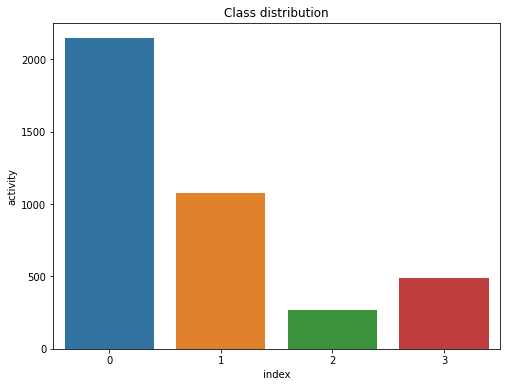

In [9]:
# Checking class distribution of training data

classes_dist = train_df["activity"].value_counts().reset_index()
plt.figure(figsize=(8,6))
chart = sns.barplot(x="index", y="activity", data=classes_dist)
# chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_title("Class distribution")

In [10]:
import torch
from torch_geometric.data import Dataset, download_url

class MoleculeDataset(Dataset):
    def __init__(self, root, filename, transform=None, test=False, pre_transform=None, pre_filter=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(MoleculeDataset, self).__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0])
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            # Get node features
            node_feats = self._get_node_features(mol_obj)
            # Get edge features
            edge_feats = self._get_edge_features(mol_obj)
            # Get adjacency info
            edge_index = self._get_adjacency_info(mol_obj)
            # Get labels info
            label = self._get_labels(mol["activity"])

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol["smiles"]
                        ) 
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

    def _get_node_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []

        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number        
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())
            # Append node features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        label = label.astype(np.int64)
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))        
        return data

# **GNN Architecture**

In [11]:
import torch
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling 
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from tqdm import tqdm
torch.manual_seed(42)

In [12]:
class GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(GNN, self).__init__()
        embedding_size = 128
        n_heads = 4
        self.n_layers = 2
        dropout_rate = 0.9
        top_k_ratio = 0.85
        self.top_k_every_n = 3

        self.conv_layers = ModuleList([])
        self.transf_layers = ModuleList([])
        self.pooling_layers = ModuleList([])
        self.bn_layers = ModuleList([])

        # Transformation layer
        self.conv1 = TransformerConv(feature_size, 
                                    embedding_size, 
                                    heads=n_heads, 
                                    dropout=dropout_rate,
                                    edge_dim=2) 

        self.transf1 = Linear(embedding_size*n_heads, embedding_size)
        self.bn1 = BatchNorm1d(embedding_size)

        # Other layers
        for i in range(self.n_layers):
            self.conv_layers.append(TransformerConv(embedding_size, 
                                                    embedding_size, 
                                                    heads=n_heads, 
                                                    dropout=dropout_rate,
                                                    edge_dim=2))

            self.transf_layers.append(Linear(embedding_size*n_heads, embedding_size))
            self.bn_layers.append(BatchNorm1d(embedding_size))
            if i % self.top_k_every_n == 0:
                self.pooling_layers.append(TopKPooling(embedding_size, ratio=top_k_ratio))
            

        # Linear layers
        self.linear1 = Linear(embedding_size*2, 256)
        self.linear2 = Linear(256, 64)  
        self.linear3 = Linear(64, 4)  

    def forward(self, x, edge_attr, edge_index, batch_index):
        # Initial transformation
        x = self.conv1(x, edge_index, edge_attr)
        x = self.transf1(x)
        x = self.bn1(x)

        # Holds the intermediate graph representations
        global_representation = []

        for i in range(self.n_layers):
            x = self.conv_layers[i](x, edge_index, edge_attr)
            x = self.transf_layers[i](x)
            x = self.bn_layers[i](x)
            if i % self.top_k_every_n == 0 or i == self.n_layers:
                x , edge_index, edge_attr, batch_index, _, _ = self.pooling_layers[int(i/self.top_k_every_n)](
                    x, edge_index, edge_attr, batch_index
                    )
                # Add current representation
                global_representation.append(torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1))
    
        x = sum(global_representation)

        # Output block
        x = self.linear1(x).tanh()
        x = F.dropout(x, p=0.8, training=self.training)
        x = self.linear2(x).tanh()
        x = F.dropout(x, p=0.8, training=self.training)
        x = self.linear3(x)

        return x

# **Training the data**

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
train_dataset = MoleculeDataset(root="/content/data/", filename="train.csv")
test_dataset = MoleculeDataset(root="/content/data/", filename="test.csv")

Processing...
100%|██████████| 3977/3977 [00:11<00:00, 354.84it/s]
Done!


In [14]:
train_dataset[9].edge_attr.shape

torch.Size([88, 2])

In [15]:
def count_parameters(model):  
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
# Loading the model

model = GNN(feature_size=train_dataset[0].x.shape[1])
model = model.to(device)
print(f"Number of parameters: {count_parameters(model)}")
model

Number of parameters: 832324


GNN(
  (conv_layers): ModuleList(
    (0): TransformerConv(128, 128, heads=4)
    (1): TransformerConv(128, 128, heads=4)
  )
  (transf_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Linear(in_features=512, out_features=128, bias=True)
  )
  (pooling_layers): ModuleList(
    (0): TopKPooling(128, ratio=0.85, multiplier=1.0)
  )
  (bn_layers): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1): TransformerConv(9, 128, heads=4)
  (transf1): Linear(in_features=512, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=256, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=4, bias=True)
)

In [17]:
# Loss and Optimizer 
# weights = torch.tensor([1,10], dtype=torch.float32).to(device)
# loss_fn = torch.nn.CrossEntropyLoss(weight=weights)
loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [18]:
# NUM_GRAPHS_PER_BATCH = 256
NUM_GRAPHS_PER_BATCH = 64
train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle = True)

In [19]:
def train(epoch):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for _, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)  
        # Reset gradients
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        # pred = model(batch.x.float(), 
        #                         batch.edge_attr.float(),
        #                         batch.edge_index, 
        #                         batch.batch) 
        pred_labels = model(batch.x, 
                                batch.edge_attr,
                                batch.edge_index, 
                                batch.batch) 
        # print("raw : ", pred_labels.size())
        # print("raw type : ", pred_labels.dtype)
        # print("batch y: ", batch.y.size())
        
        # Calculating the loss and gradients
        # loss = loss_fn(torch.squeeze(pred_labels), batch.y)
        loss = loss_fn(pred_labels, batch.y.long())
        loss.backward()  
        optimizer.step()  

        # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.softmax(pred_labels, dim=1).cpu().detach().numpy()))
        all_labels.append(batch.y.cpu().detach().numpy())
        # print("all preds : ", np.array(all_preds).shape)
        # print("all_labels: ", np.array(all_labels).shape)
    # all_preds = np.concatenate(all_preds).ravel()
    # all_labels = np.concatenate(all_labels).ravel()
    all_preds = np.concatenate(all_preds)
    all_ps = torch.argmax(torch.from_numpy(all_preds), axis=1).cpu().numpy()
    all_labels = np.concatenate(all_labels)
    # print("all_p shape", all_ps.shape)
    # print("all_L shape", all_labels.shape)
    calculate_metrics(all_ps, all_labels, epoch, "train")
    return running_loss/step

In [26]:
def test(epoch):
    all_preds = []
    all_preds_raw = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for batch in test_loader:
        batch.to(device)  
        # pred = model(batch.x.float(), 
        #                 batch.edge_attr.float(),
        #                 batch.edge_index, 
        #                 batch.batch)
        pred = model(batch.x, 
                        batch.edge_attr,
                        batch.edge_index, 
                        batch.batch) 
        loss = loss_fn(pred, batch.y.long())
        # loss = loss_fn(torch.squeeze(pred), batch.y)  #original

         # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.softmax(pred, dim=1).cpu().detach().numpy()))
        all_preds_raw.append(torch.softmax(pred, dim=1).cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_ps = torch.argmax(torch.from_numpy(all_preds), axis=1).cpu().numpy()
    all_labels = np.concatenate(all_labels)
    calculate_metrics(all_ps, all_labels, epoch, "test")
    return running_loss/step

In [27]:
def calculate_metrics(y_pred, y_true, epoch, type):
    # print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='macro')}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    # mlflow.log_metric(key=f"Precision-{type}", value=float(prec), step=epoch)
    # mlflow.log_metric(key=f"Recall-{type}", value=float(rec), step=epoch)
    try:
        roc = roc_auc_score(y_true, y_pred)
        print(f"ROC AUC: {roc}")
        # mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(roc), step=epoch)
    except:
        # mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"ROC AUC: notdefined")

In [28]:
for epoch in range(300): 
    # Training
    model.train()
    loss = train(epoch=epoch)
    # loss = loss.detach().cpu().numpy()
    print(f"Epoch {epoch} | Train Loss {loss}")

    # Testing
    model.eval()
    if epoch % 5 == 0:
        loss = test(epoch = epoch)
        # loss = loss.detach().cpu().numpy()
        print(f"Epochs {epoch} | test Loss {loss}")

    scheduler.step()
print("Done!")


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  2%|▏         | 1/63 [00:00<00:27,  2.27it/s]

all preds :  (1, 64, 4)
all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  3%|▎         | 2/63 [00:00<00:28,  2.17it/s]

all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

  5%|▍         | 3/63 [00:01<00:26,  2.30it/s]

 (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32

  6%|▋         | 4/63 [00:01<00:24,  2.37it/s]


batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:02<00:24,  2.33it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 10%|▉         | 6/63 [00:02<00:27,  2.08it/s]

all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:03<00:29,  1.88it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:30,  1.79it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:04<00:30,  1.77it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:05<00:30,  1.76it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:05<00:29,  1.76it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:06<00:26,  1.95it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:06<00:23,  2.13it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:06<00:21,  2.25it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:07<00:20,  2.31it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  

 25%|██▌       | 16/63 [00:07<00:19,  2.36it/s]

(16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:08<00:19,  2.42it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 29%|██▊       | 18/63 [00:08<00:18,  2.42it/s]

 (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])


 30%|███       | 19/63 [00:08<00:17,  2.45it/s]

raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:09<00:17,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:09<00:16,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:10<00:16,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:10<00:15,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:10<00:15,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:14,  2.56it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:11<00:14,  2.56it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:11<00:14,  2.56it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:13,  2.58it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:12<00:13,  2.61it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:12,  2.58it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)


 49%|████▉     | 31/63 [00:13<00:12,  2.55it/s]

all_labels:  (31, 64)


 51%|█████     | 32/63 [00:13<00:12,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:11,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:14<00:11,  2.52it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:15<00:11,  2.53it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 57%|█████▋    | 36/63 [00:15<00:10,  2.55it/s]

all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 59%|█████▊    | 37/63 [00:16<00:11,  2.32it/s]

all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:16<00:12,  2.07it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:12,  1.91it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:17<00:12,  1.86it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:12,  1.79it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:19<00:11,  1.79it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 68%|██████▊   | 43/63 [00:19<00:10,  1.87it/s]

 (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:19<00:09,  2.05it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 71%|███████▏  | 45/63 [00:20<00:08,  2.18it/s]

all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:20<00:07,  2.25it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:21<00:06,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:21<00:06,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:21<00:05,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:22<00:05,  2.45it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:22<00:04,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:23<00:04,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:23<00:04,  2.49it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:23<00:03,  2.45it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:24<00:03,  2.48it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:24<00:02,  2.51it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:25<00:02,  2.51it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:25<00:01,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:25<00:01,  2.56it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:26<00:01,  2.55it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:26<00:00,  2.47it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:27<00:00,  2.47it/s]

all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.32it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.18634593702207553
Accuracy: 0.528539099823988
Precision: 0.19702535760728218
Recall: 0.2487042415310258
ROC AUC: notdefined
Epoch 0 | Train Loss 1.2085739979668269


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1553, 4)
(1553,)
F1 Score: 0.1356170811825434
Accuracy: 0.37218287186091437
Precision: 0.09304571796522859
Recall: 0.25
ROC AUC: notdefined
Epochs 0 | test Loss 1.2625874519348144


  2%|▏         | 1/63 [00:00<00:28,  2.15it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:26,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:25,  2.36it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:01<00:24,  2.45it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:02<00:23,  2.47it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:23,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:02<00:22,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:22,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:21,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)


 16%|█▌        | 10/63 [00:04<00:20,  2.56it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:04<00:20,  2.55it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:04<00:20,  2.53it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:05<00:19,  2.51it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:05<00:19,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:06<00:19,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:06<00:18,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:06<00:18,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:07<00:17,  2.50it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:07<00:17,  2.54it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:08<00:16,  2.56it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:08<00:16,  2.58it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 35%|███▍      | 22/63 [00:08<00:16,  2.53it/s]

 (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:09<00:15,  2.52it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:09<00:15,  2.58it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:09<00:14,  2.58it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:10<00:14,  2.53it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:10<00:16,  2.18it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:11<00:17,  1.98it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:12<00:18,  1.86it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:12<00:18,  1.78it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:18,  1.77it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:13<00:17,  1.82it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:14,  2.01it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:14<00:13,  2.18it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:12,  2.27it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 57%|█████▋    | 36/63 [00:15<00:11,  2.33it/s]

all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 59%|█████▊    | 37/63 [00:15<00:10,  2.37it/s]

all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:16<00:10,  2.42it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:16<00:09,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:17<00:08,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:17<00:08,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:18<00:07,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:18<00:07,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:19<00:06,  2.50it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:19<00:06,  2.50it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:20<00:05,  2.55it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:20<00:05,  2.56it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:20<00:05,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:21<00:04,  2.57it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:21<00:04,  2.55it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:22<00:03,  2.52it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:22<00:03,  2.53it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:22<00:03,  2.56it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:23<00:02,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:23<00:02,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:24<00:02,  2.27it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:24<00:01,  2.06it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:25<00:01,  1.92it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:26<00:01,  1.80it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:26<00:00,  1.74it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:26<00:00,  2.35it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.18643705379232342
Accuracy: 0.5333165702791048
Precision: 0.20993804852865255
Recall: 0.25056947484774267
ROC AUC: notdefined
Epoch 1 | Train Loss 1.194355483092959


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  2%|▏         | 1/63 [00:00<00:33,  1.86it/s]

all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:29,  2.05it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:27,  2.22it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:01<00:25,  2.35it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:02<00:23,  2.44it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:23,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:02<00:23,  2.42it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:22,  2.41it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:03<00:21,  2.53it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:20,  2.55it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:04<00:20,  2.49it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:04<00:20,  2.51it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:05<00:19,  2.53it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:05<00:19,  2.54it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:06<00:18,  2.55it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:06<00:18,  2.55it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:06<00:18,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:07<00:18,  2.48it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:07<00:17,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:08<00:17,  2.48it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:08<00:16,  2.51it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:08<00:16,  2.51it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:09<00:16,  2.44it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:09<00:16,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:10<00:15,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:10<00:14,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:11<00:16,  2.22it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:11<00:17,  1.96it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:12<00:18,  1.88it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:12<00:17,  1.86it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:17,  1.81it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:14<00:17,  1.81it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:15,  1.92it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:14<00:13,  2.08it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:12,  2.24it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:15<00:11,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:10,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:16<00:10,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:16<00:09,  2.46it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:17<00:09,  2.46it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:17<00:08,  2.50it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:18<00:08,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:18<00:08,  2.43it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:18<00:07,  2.44it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 71%|███████▏  | 45/63 [00:19<00:07,  2.49it/s]

all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:19<00:06,  2.48it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:20<00:06,  2.49it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:20<00:05,  2.52it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:20<00:05,  2.52it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:21<00:05,  2.52it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:21<00:04,  2.52it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:21<00:04,  2.55it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:22<00:03,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:22<00:03,  2.52it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:23<00:03,  2.54it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)


 89%|████████▉ | 56/63 [00:23<00:02,  2.50it/s]

all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:23<00:02,  2.54it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:24<00:02,  2.44it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:25<00:01,  2.11it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:25<00:01,  1.97it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:26<00:01,  1.82it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:26<00:00,  1.76it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:26<00:00,  2.33it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.18328033064969665
Accuracy: 0.5345737993462408
Precision: 0.19988925013308995
Recall: 0.25010739287804246
ROC AUC: notdefined
Epoch 2 | Train Loss 1.1901661498206002


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  2%|▏         | 1/63 [00:00<00:36,  1.69it/s]

all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:01<00:31,  1.95it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:27,  2.17it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:26,  2.25it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:02<00:25,  2.31it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 10%|▉         | 6/63 [00:02<00:23,  2.40it/s]

all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:03<00:22,  2.44it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:22,  2.46it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:21,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:22,  2.40it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:04<00:25,  2.05it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:05<00:26,  1.94it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:06<00:26,  1.86it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:06<00:27,  1.80it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:07<00:27,  1.77it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:07<00:25,  1.82it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:08<00:22,  2.01it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:08<00:21,  2.14it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:08<00:19,  2.26it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:09<00:18,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:09<00:17,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:10<00:16,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:10<00:16,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:10<00:16,  2.39it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:11<00:17,  2.15it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:12<00:19,  1.94it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:12<00:19,  1.87it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:13<00:19,  1.82it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:13<00:19,  1.78it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:14<00:18,  1.78it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:14<00:16,  1.96it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:15<00:14,  2.09it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:15<00:13,  2.19it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:16<00:12,  2.31it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:16<00:11,  2.36it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 57%|█████▋    | 36/63 [00:16<00:11,  2.41it/s]

all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 59%|█████▊    | 37/63 [00:17<00:10,  2.44it/s]

all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:17<00:10,  2.47it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:18<00:09,  2.50it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:18<00:09,  2.47it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:08,  2.53it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:19<00:08,  2.54it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:19<00:07,  2.54it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:20<00:07,  2.57it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 71%|███████▏  | 45/63 [00:20<00:07,  2.54it/s]

all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:20<00:06,  2.49it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:21<00:06,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:21<00:05,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:22<00:05,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:22<00:05,  2.50it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:22<00:04,  2.54it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:23<00:04,  2.53it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:23<00:03,  2.52it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:24<00:03,  2.54it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)

 87%|████████▋ | 55/63 [00:24<00:03,  2.50it/s]


all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:24<00:03,  2.29it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:25<00:02,  2.01it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:26<00:02,  1.88it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:26<00:02,  1.82it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:27<00:01,  1.79it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:27<00:01,  1.80it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:28<00:00,  1.88it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.21it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17994673937822148
Accuracy: 0.538345486547649
Precision: 0.21372371283538796
Recall: 0.2506942066364681
ROC AUC: notdefined
Epoch 3 | Train Loss 1.1954705601646787


  2%|▏         | 1/63 [00:00<00:23,  2.59it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:24,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:24,  2.48it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:01<00:22,  2.57it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:01<00:22,  2.56it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  

 10%|▉         | 6/63 [00:02<00:22,  2.48it/s]

(6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:02<00:22,  2.52it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:21,  2.53it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:21,  2.55it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)


 16%|█▌        | 10/63 [00:03<00:20,  2.61it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:04<00:20,  2.58it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:04<00:20,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:19,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:05<00:19,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:05<00:19,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:06<00:18,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:06<00:18,  2.55it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:07<00:17,  2.57it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:07<00:17,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:07<00:16,  2.57it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:08<00:16,  2.59it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:08<00:15,  2.61it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:09<00:15,  2.55it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:09<00:15,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:09<00:15,  2.44it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:10<00:17,  2.14it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:11<00:18,  1.98it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:11<00:18,  1.85it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:12<00:19,  1.76it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:12<00:19,  1.74it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:17,  1.79it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:13<00:15,  1.98it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:14,  2.12it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:14<00:13,  2.23it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:14<00:12,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:15<00:11,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:15<00:10,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:16<00:10,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:16<00:09,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:16<00:09,  2.46it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:17<00:08,  2.48it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:17<00:08,  2.52it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:18<00:08,  2.49it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:18<00:07,  2.45it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 71%|███████▏  | 45/63 [00:18<00:07,  2.49it/s]

all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:19<00:06,  2.54it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:19<00:06,  2.56it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:20<00:05,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:20<00:05,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 79%|███████▉  | 50/63 [00:20<00:05,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:21<00:04,  2.54it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:21<00:04,  2.57it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:22<00:03,  2.54it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:22<00:03,  2.52it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:22<00:03,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:23<00:02,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:23<00:02,  2.14it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:24<00:02,  1.91it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:25<00:02,  1.80it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:25<00:01,  1.73it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:26<00:01,  1.71it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:27<00:00,  1.73it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.32it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.18391223401217577
Accuracy: 0.5330651244656777
Precision: 0.20522338431775589
Recall: 0.24975660504128827
ROC AUC: notdefined
Epoch 4 | Train Loss 1.1869411383356367


  2%|▏         | 1/63 [00:00<00:23,  2.59it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:23,  2.55it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:23,  2.58it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:23,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:01<00:23,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:22,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:02<00:22,  2.53it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:21,  2.58it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)


 14%|█▍        | 9/63 [00:03<00:21,  2.54it/s]

raw :  torch.Size([64, 4])
raw type : 

 16%|█▌        | 10/63 [00:03<00:20,  2.53it/s]

 torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:04<00:20,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:04<00:20,  2.47it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:05<00:20,  2.48it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:05<00:19,  2.51it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:05<00:19,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:06<00:18,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:06<00:18,  2.49it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:07<00:17,  2.52it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:07<00:17,  2.53it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:07<00:17,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)


 33%|███▎      | 21/63 [00:08<00:17,  2.46it/s]

all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:08<00:16,  2.50it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:09<00:15,  2.51it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:09<00:15,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:10<00:16,  2.29it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:10<00:21,  1.76it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:11<00:21,  1.71it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:12<00:20,  1.72it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:12<00:19,  1.75it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:18,  1.75it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:18,  1.76it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:16,  1.90it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:14,  2.05it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:15<00:13,  2.12it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:15<00:12,  2.21it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 57%|█████▋    | 36/63 [00:15<00:11,  2.29it/s]

all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])


 59%|█████▊    | 37/63 [00:16<00:11,  2.36it/s]

raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)


 60%|██████    | 38/63 [00:16<00:10,  2.38it/s]

all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:10,  2.39it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:17<00:09,  2.38it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:17<00:09,  2.43it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)

 67%|██████▋   | 42/63 [00:18<00:08,  2.43it/s]


all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:18<00:08,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:19<00:07,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 73%|███████▎  | 46/63 [00:19<00:06,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:20<00:06,  2.48it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:20<00:05,  2.53it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:21<00:05,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:21<00:05,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:21<00:04,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:22<00:04,  2.46it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:22<00:04,  2.48it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:23<00:03,  2.52it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)


 87%|████████▋ | 55/63 [00:23<00:03,  2.50it/s]

all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:23<00:02,  2.49it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:24<00:02,  2.16it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:25<00:02,  1.98it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:25<00:02,  1.89it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:26<00:01,  1.81it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:26<00:01,  1.78it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:27<00:00,  1.76it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.28it/s]

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.18294689683223792
Accuracy: 0.5350766909730953
Precision: 0.20259190781865646
Recall: 0.2502243221569605
ROC AUC: notdefined
Epoch 5 | Train Loss 1.1849988944946774



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1553, 4)
(1553,)
F1 Score: 0.1356170811825434
Accuracy: 0.37218287186091437
Precision: 0.09304571796522859
Recall: 0.25
ROC AUC: notdefined
Epochs 5 | test Loss 1.2962936210632323


  2%|▏         | 1/63 [00:00<00:24,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:23,  2.59it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:24,  2.40it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:01<00:24,  2.45it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:01<00:22,  2.53it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 10%|▉         | 6/63 [00:02<00:22,  2.48it/s]

all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:02<00:22,  2.52it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:21,  2.54it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:03<00:21,  2.50it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:03<00:21,  2.51it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:04<00:20,  2.51it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:04<00:19,  2.55it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:05<00:19,  2.54it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:05<00:19,  2.46it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:06<00:20,  2.29it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:06<00:22,  2.06it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:07<00:23,  1.93it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:07<00:24,  1.81it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:08<00:25,  1.74it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:09<00:25,  1.72it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:09<00:23,  1.78it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:10<00:21,  1.95it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:10<00:19,  2.09it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:10<00:17,  2.21it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:11<00:16,  2.33it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:11<00:15,  2.39it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:12<00:14,  2.47it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:12<00:14,  2.49it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:12<00:14,  2.42it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:13,  2.47it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:12,  2.52it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:14<00:12,  2.46it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:11,  2.50it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:14<00:11,  2.50it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:15<00:11,  2.51it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:15<00:10,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:10,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:16<00:10,  2.43it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:16<00:09,  2.43it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:17<00:09,  2.47it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:17<00:08,  2.50it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:18<00:08,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:18<00:08,  2.44it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:18<00:07,  2.46it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 71%|███████▏  | 45/63 [00:19<00:07,  2.50it/s]

all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:19<00:06,  2.45it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:20<00:07,  2.08it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:20<00:07,  1.94it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:21<00:07,  1.84it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:22<00:07,  1.79it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:22<00:06,  1.75it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:23<00:06,  1.77it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:23<00:05,  1.94it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:24<00:04,  2.10it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:24<00:03,  2.20it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:24<00:03,  2.29it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:25<00:02,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:25<00:02,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:26<00:01,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:26<00:01,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:26<00:00,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:27<00:00,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.30it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.18546614596467967
Accuracy: 0.5363339200402313
Precision: 0.22520349499089254
Recall: 0.2515031751880188
ROC AUC: notdefined
Epoch 6 | Train Loss 1.1686062718194627


  2%|▏         | 1/63 [00:00<00:24,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:24,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:23,  2.55it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:23,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:01<00:23,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:22,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:02<00:22,  2.50it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:21,  2.57it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:03<00:21,  2.55it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:03<00:21,  2.51it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:04<00:20,  2.48it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:04<00:20,  2.46it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32


 21%|██        | 13/63 [00:05<00:20,  2.49it/s]

batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 22%|██▏       | 14/63 [00:05<00:19,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:06<00:19,  2.44it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:06<00:21,  2.18it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:07<00:23,  1.99it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:07<00:23,  1.88it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:08<00:24,  1.80it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:08<00:24,  1.79it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:09<00:23,  1.78it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:09<00:21,  1.93it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:10<00:19,  2.10it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:10<00:17,  2.20it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:16,  2.27it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:11<00:15,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:11<00:15,  2.37it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:12<00:14,  2.41it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:12<00:13,  2.46it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:13,  2.47it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:13<00:12,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:13<00:12,  2.45it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:12,  2.48it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:14<00:11,  2.50it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:15<00:11,  2.48it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  

 57%|█████▋    | 36/63 [00:15<00:10,  2.49it/s]

torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 59%|█████▊    | 37/63 [00:15<00:10,  2.48it/s]

 (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:16<00:10,  2.47it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:16<00:09,  2.49it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:17<00:09,  2.51it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:17<00:08,  2.45it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:17<00:08,  2.46it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:18<00:08,  2.47it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:18<00:07,  2.44it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:19<00:06,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:20<00:07,  2.24it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:20<00:07,  1.98it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:21<00:07,  1.85it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:22<00:07,  1.78it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:22<00:06,  1.75it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:23<00:06,  1.76it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:23<00:05,  1.88it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:24<00:04,  2.01it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:24<00:03,  2.14it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:24<00:03,  2.25it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:25<00:02,  2.33it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:25<00:02,  2.39it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  

 94%|█████████▎| 59/63 [00:26<00:01,  2.41it/s]

(59, 64)


 95%|█████████▌| 60/63 [00:26<00:01,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:26<00:00,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:27<00:00,  2.40it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.30it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1795445873062408
Accuracy: 0.5333165702791048
Precision: 0.18959214749829123
Recall: 0.2485964151802163
ROC AUC: notdefined
Epoch 7 | Train Loss 1.1898422099295116


  2%|▏         | 1/63 [00:00<00:23,  2.59it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:24,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:24,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:23,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:02<00:24,  2.40it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:23,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:02<00:23,  2.38it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:22,  2.44it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:22,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)


 16%|█▌        | 10/63 [00:04<00:21,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:04<00:21,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:04<00:20,  2.44it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:20,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:05<00:19,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:06<00:20,  2.37it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:06<00:21,  2.14it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:07<00:23,  1.94it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:08<00:24,  1.82it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:08<00:24,  1.77it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:09<00:24,  1.73it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:09<00:24,  1.75it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:10<00:21,  1.94it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:10<00:18,  2.11it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:10<00:17,  2.22it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)


 40%|███▉      | 25/63 [00:11<00:16,  2.25it/s]

all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:11<00:16,  2.28it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:12<00:15,  2.33it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:12<00:14,  2.38it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:13<00:14,  2.37it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:13,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:13,  2.43it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:14<00:12,  2.45it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:11,  2.50it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:15<00:11,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:15<00:10,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:10,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:16<00:09,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:17<00:09,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:17<00:08,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:18<00:08,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:18<00:07,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:18<00:07,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:19<00:06,  2.49it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:20<00:07,  2.18it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:21<00:07,  1.99it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:21<00:07,  1.90it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:22<00:07,  1.83it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:22<00:06,  1.77it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:23<00:06,  1.75it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:23<00:05,  1.88it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:24<00:04,  2.02it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:24<00:03,  2.14it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:25<00:03,  2.25it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:25<00:02,  2.28it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:25<00:02,  2.33it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:26<00:01,  2.40it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:26<00:01,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:27<00:00,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:27<00:00,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.29it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.18261913056389992
Accuracy: 0.532310787025396
Precision: 0.19639985490599118
Recall: 0.24905893062268364
ROC AUC: notdefined
Epoch 8 | Train Loss 1.1771330360382322


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  3%|▎         | 2/63 [00:00<00:24,  2.52it/s]

all preds :  (1, 64, 4)
all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:24,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:23,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:23,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:22,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:02<00:22,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:22,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:21,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels: 

 16%|█▌        | 10/63 [00:03<00:21,  2.50it/s]

 (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:04<00:21,  2.45it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:04<00:20,  2.47it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:05<00:20,  2.43it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:05<00:19,  2.49it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:06<00:19,  2.49it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:06<00:22,  2.10it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:07<00:23,  1.97it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:07<00:24,  1.85it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:08<00:25,  1.76it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:09<00:24,  1.74it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:09<00:24,  1.71it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:10<00:21,  1.88it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:10<00:19,  2.03it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:10<00:18,  2.16it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:17,  2.23it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:11<00:15,  2.33it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:12<00:15,  2.37it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels: 

 44%|████▍     | 28/63 [00:12<00:14,  2.40it/s]

 (28, 64)


 46%|████▌     | 29/63 [00:12<00:14,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:13,  2.42it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:13,  2.45it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:14,  2.20it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:13,  2.27it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:15<00:12,  2.33it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 57%|█████▋    | 36/63 [00:15<00:11,  2.40it/s]

all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])


 59%|█████▊    | 37/63 [00:16<00:10,  2.43it/s]

raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:16<00:10,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:17<00:09,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 65%|██████▌   | 41/63 [00:17<00:08,  2.48it/s]

 (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])

 67%|██████▋   | 42/63 [00:18<00:08,  2.48it/s]


raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:18<00:08,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:19<00:07,  2.48it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:20<00:07,  2.34it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:20<00:07,  2.07it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:21<00:07,  1.94it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:21<00:07,  1.86it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:22<00:07,  1.81it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:22<00:06,  1.76it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:23<00:06,  1.77it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:23<00:05,  1.94it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:24<00:04,  2.05it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:24<00:03,  2.21it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:25<00:03,  2.28it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:25<00:02,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:25<00:02,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:26<00:01,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:26<00:01,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:27<00:00,  2.43it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:27<00:00,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.28it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17818761384335158
Accuracy: 0.5385969323610762
Precision: 0.21107684018385345
Recall: 0.25034645310908343
ROC AUC: notdefined
Epoch 9 | Train Loss 1.169763580201164


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)

  2%|▏         | 1/63 [00:00<00:25,  2.42it/s]


all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  3%|▎         | 2/63 [00:00<00:25,  2.43it/s]

all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:23,  2.53it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:01<00:23,  2.54it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:01<00:22,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:22,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:02<00:22,  2.49it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:22,  2.48it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:03<00:22,  2.43it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:21,  2.45it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:04<00:20,  2.51it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:04<00:20,  2.48it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:20,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:05<00:20,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:06<00:21,  2.28it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:06<00:23,  2.01it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:07<00:24,  1.86it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:08<00:25,  1.79it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:08<00:25,  1.76it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:09<00:25,  1.71it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:09<00:23,  1.80it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:10<00:20,  1.98it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:10<00:18,  2.12it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:10<00:17,  2.25it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:16,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:11<00:15,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:12<00:14,  2.42it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:14,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:12<00:13,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:13,  2.45it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:12,  2.50it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:14<00:12,  2.50it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:11,  2.52it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:14<00:11,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:15<00:10,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:10,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:16<00:11,  2.15it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:12,  1.96it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:17<00:12,  1.84it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:12,  1.82it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:19<00:11,  1.76it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:19<00:11,  1.74it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:20<00:11,  1.67it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 71%|███████▏  | 45/63 [00:20<00:10,  1.67it/s]

all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:21<00:10,  1.67it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:22<00:09,  1.66it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:22<00:09,  1.66it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:23<00:08,  1.68it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:23<00:07,  1.79it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:24<00:06,  1.96it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:24<00:05,  2.09it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:25<00:04,  2.21it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:25<00:03,  2.29it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:25<00:03,  2.31it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:26<00:02,  2.37it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:26<00:02,  2.44it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:26<00:02,  2.49it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:27<00:01,  2.50it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)

 95%|█████████▌| 60/63 [00:27<00:01,  2.49it/s]

 97%|█████████▋| 61/63 [00:28<00:00,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:28<00:00,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.20it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1786419268622532
Accuracy: 0.5370882574805129
Precision: 0.20733736082271964
Recall: 0.24987960293894537
ROC AUC: notdefined
Epoch 10 | Train Loss 1.1648326024176583


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1553, 4)
(1553,)
F1 Score: 0.1356170811825434
Accuracy: 0.37218287186091437
Precision: 0.09304571796522859
Recall: 0.25
ROC AUC: notdefined
Epochs 10 | test Loss 1.2604751634597777


  2%|▏         | 1/63 [00:00<00:23,  2.64it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  3%|▎         | 2/63 [00:00<00:26,  2.33it/s]

all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:32,  1.87it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:02<00:33,  1.76it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:02<00:33,  1.72it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 10%|▉         | 6/63 [00:03<00:33,  1.72it/s]

all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:03<00:33,  1.68it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:04<00:31,  1.76it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:04<00:27,  1.94it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:05<00:25,  2.07it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:05<00:24,  2.14it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:06<00:22,  2.24it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:06<00:21,  2.31it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)

 22%|██▏       | 14/63 [00:06<00:20,  2.35it/s]


raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:07<00:19,  2.44it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:07<00:19,  2.45it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:08<00:18,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:08<00:18,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:08<00:17,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:09<00:16,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:09<00:16,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:10<00:16,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:10<00:15,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:10<00:15,  2.57it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:14,  2.59it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:11<00:14,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:14,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:13,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:12<00:13,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:12,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:13<00:12,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:13<00:12,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:11,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:14<00:13,  2.18it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:15<00:13,  2.02it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 57%|█████▋    | 36/63 [00:16<00:14,  1.90it/s]

all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 59%|█████▊    | 37/63 [00:16<00:14,  1.82it/s]

all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:17<00:14,  1.76it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:14,  1.71it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:18<00:12,  1.82it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:18<00:11,  1.99it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:19<00:09,  2.13it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 68%|██████▊   | 43/63 [00:19<00:09,  2.22it/s]

 (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)


 70%|██████▉   | 44/63 [00:20<00:08,  2.28it/s]

all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 71%|███████▏  | 45/63 [00:20<00:07,  2.36it/s]

all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:20<00:07,  2.41it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:21<00:06,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:21<00:06,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:22<00:05,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:22<00:05,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:22<00:04,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:23<00:04,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:23<00:03,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:23<00:03,  2.55it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:24<00:03,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:24<00:02,  2.55it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:25<00:02,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:25<00:01,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:25<00:01,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:26<00:01,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:26<00:00,  2.47it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw : 

 98%|█████████▊| 62/63 [00:27<00:00,  2.50it/s]

 torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.31it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17942607805291405
Accuracy: 0.5363339200402313
Precision: 0.19880351379151345
Recall: 0.24976224018726023
ROC AUC: notdefined
Epoch 11 | Train Loss 1.1737133709211198


  2%|▏         | 1/63 [00:00<00:22,  2.71it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:23,  2.61it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:27,  2.16it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:01<00:30,  1.92it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:02<00:32,  1.76it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 10%|▉         | 6/63 [00:03<00:32,  1.75it/s]

all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:03<00:31,  1.76it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:04<00:31,  1.74it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:04<00:29,  1.80it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:05<00:27,  1.96it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:05<00:24,  2.11it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:06<00:22,  2.24it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:06<00:21,  2.31it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:06<00:20,  2.39it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:07<00:19,  2.47it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:07<00:18,  2.50it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:07<00:18,  2.54it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw : 

 29%|██▊       | 18/63 [00:08<00:17,  2.54it/s]

 torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:08<00:17,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:09<00:17,  2.48it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:09<00:16,  2.48it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:09<00:16,  2.49it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:10<00:15,  2.51it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:10<00:15,  2.51it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:11<00:14,  2.55it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:11<00:14,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:11<00:14,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:13,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:12<00:13,  2.57it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:12,  2.61it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:13<00:12,  2.58it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:13<00:12,  2.55it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)


 52%|█████▏    | 33/63 [00:14<00:11,  2.53it/s]

all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:14<00:11,  2.52it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:15<00:12,  2.27it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 57%|█████▋    | 36/63 [00:15<00:13,  2.03it/s]

all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 59%|█████▊    | 37/63 [00:16<00:13,  1.93it/s]

all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:16<00:13,  1.84it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:13,  1.77it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:18<00:13,  1.76it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:12,  1.79it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:19<00:10,  1.97it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:19<00:09,  2.08it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:19<00:08,  2.19it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:20<00:07,  2.26it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:20<00:07,  2.29it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:21<00:06,  2.34it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:21<00:06,  2.37it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:21<00:05,  2.42it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:22<00:05,  2.40it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:22<00:04,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:23<00:04,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:23<00:04,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:24<00:03,  2.43it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:24<00:03,  2.43it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:24<00:02,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:25<00:02,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:25<00:02,  2.43it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:26<00:01,  2.47it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:26<00:01,  2.47it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:26<00:00,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:27<00:00,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.31it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17792774655158583
Accuracy: 0.5370882574805129
Precision: 0.18960511723700887
Recall: 0.24964747827217756
ROC AUC: notdefined
Epoch 12 | Train Loss 1.1630226808881003


  2%|▏         | 1/63 [00:00<00:25,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:24,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:24,  2.46it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:01<00:28,  2.09it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:02<00:30,  1.91it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 10%|▉         | 6/63 [00:03<00:31,  1.80it/s]

all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:03<00:32,  1.73it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:04<00:32,  1.70it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:04<00:31,  1.72it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)


 16%|█▌        | 10/63 [00:05<00:28,  1.84it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:05<00:26,  1.99it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:06<00:23,  2.16it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:06<00:22,  2.27it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:06<00:20,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:07<00:20,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:07<00:19,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:08<00:18,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:08<00:18,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:08<00:17,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:09<00:17,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:09<00:17,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:10<00:16,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:10<00:15,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:10<00:15,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:15,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:11<00:14,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)


 43%|████▎     | 27/63 [00:12<00:14,  2.50it/s]

all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  

 44%|████▍     | 28/63 [00:12<00:14,  2.49it/s]

(28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:12<00:13,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)


 48%|████▊     | 30/63 [00:13<00:13,  2.45it/s]

all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:13,  2.45it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:14<00:12,  2.49it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:12,  2.50it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:14<00:11,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:15<00:12,  2.33it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 57%|█████▋    | 36/63 [00:15<00:13,  2.07it/s]

all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 59%|█████▊    | 37/63 [00:16<00:13,  1.96it/s]

all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:17<00:13,  1.84it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:13,  1.78it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:18<00:13,  1.76it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:12,  1.76it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:19<00:10,  1.94it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])


 68%|██████▊   | 43/63 [00:19<00:09,  2.09it/s]

raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:20<00:08,  2.21it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:20<00:07,  2.31it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:20<00:07,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:21<00:06,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:21<00:06,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:22<00:05,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)


 79%|███████▉  | 50/63 [00:22<00:05,  2.47it/s]

all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:22<00:04,  2.49it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:23<00:04,  2.50it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:23<00:04,  2.48it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:24<00:03,  2.51it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:24<00:03,  2.52it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw : 

 89%|████████▉ | 56/63 [00:24<00:02,  2.51it/s]

 torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:25<00:02,  2.57it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:25<00:01,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:26<00:01,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:26<00:01,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:26<00:00,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:27<00:00,  2.43it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.31it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17708635119218472
Accuracy: 0.5375911491073674
Precision: 0.19164751178025516
Recall: 0.2496483452177117
ROC AUC: notdefined
Epoch 13 | Train Loss 1.1637845919245766


  2%|▏         | 1/63 [00:00<00:24,  2.56it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:24,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:24,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:01<00:25,  2.29it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:02<00:29,  1.98it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 10%|▉         | 6/63 [00:02<00:30,  1.84it/s]

all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:03<00:31,  1.77it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:04<00:31,  1.73it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:04<00:31,  1.71it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:05<00:30,  1.75it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:05<00:27,  1.92it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:06<00:24,  2.09it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:06<00:22,  2.23it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:06<00:21,  2.31it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:07<00:20,  2.38it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:08<00:18,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:08<00:18,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:08<00:17,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:09<00:17,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:09<00:17,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:10<00:16,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:10<00:16,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:10<00:15,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:15,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:11<00:14,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:14,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:13,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:12<00:13,  2.56it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:13,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  

 49%|████▉     | 31/63 [00:13<00:12,  2.51it/s]

(31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:12,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:11,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:14<00:11,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:15<00:11,  2.43it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 57%|█████▋    | 36/63 [00:15<00:12,  2.15it/s]

all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 59%|█████▊    | 37/63 [00:16<00:13,  1.98it/s]

all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:17<00:13,  1.87it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:13,  1.78it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:18<00:13,  1.71it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:12,  1.70it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:19<00:11,  1.82it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:19<00:10,  1.99it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:20<00:09,  2.11it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:20<00:08,  2.22it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:20<00:07,  2.30it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:21<00:06,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:21<00:06,  2.37it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:22<00:05,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:22<00:05,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:22<00:04,  2.44it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:23<00:04,  2.47it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:23<00:04,  2.48it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:24<00:03,  2.48it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:24<00:03,  2.49it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:24<00:02,  2.50it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:25<00:02,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:25<00:01,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:26<00:01,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:26<00:01,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:26<00:00,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:27<00:00,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.29it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17820980177794615
Accuracy: 0.5350766909730953
Precision: 0.19080676911353822
Recall: 0.24894763648973753
ROC AUC: notdefined
Epoch 14 | Train Loss 1.1617002174967812


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  

  2%|▏         | 1/63 [00:00<00:25,  2.47it/s]

(1, 64)


  3%|▎         | 2/63 [00:00<00:24,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:23,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:01<00:24,  2.46it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:02<00:28,  2.05it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 10%|▉         | 6/63 [00:02<00:29,  1.90it/s]

all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:03<00:30,  1.84it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:04<00:30,  1.79it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:04<00:30,  1.75it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:05<00:30,  1.76it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:05<00:28,  1.86it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:06<00:24,  2.04it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:06<00:22,  2.19it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:06<00:21,  2.29it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:07<00:20,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:07<00:19,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:08<00:19,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:08<00:18,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:08<00:17,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:09<00:17,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:09<00:17,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:10<00:16,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:10<00:16,  2.45it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:10<00:16,  2.40it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:11<00:15,  2.42it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:11<00:14,  2.47it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:14,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:14,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:12<00:13,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:13,  2.46it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type : 

 49%|████▉     | 31/63 [00:13<00:12,  2.48it/s]

 torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:12,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:12,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:14<00:12,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 57%|█████▋    | 36/63 [00:15<00:12,  2.19it/s]

all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 59%|█████▊    | 37/63 [00:16<00:13,  1.98it/s]

all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:17<00:13,  1.89it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:13,  1.78it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:18<00:13,  1.73it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:12,  1.70it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:19<00:11,  1.82it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:19<00:10,  1.96it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:20<00:09,  2.10it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:20<00:08,  2.19it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:21<00:07,  2.25it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:21<00:06,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  

 76%|███████▌  | 48/63 [00:21<00:06,  2.38it/s]

(48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:22<00:05,  2.42it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:22<00:05,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:23<00:04,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:23<00:04,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 84%|████████▍ | 53/63 [00:23<00:04,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  

 86%|████████▌ | 54/63 [00:24<00:03,  2.48it/s]

(54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:24<00:03,  2.50it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)


 89%|████████▉ | 56/63 [00:25<00:02,  2.48it/s]

all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:25<00:02,  2.50it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:25<00:01,  2.50it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 94%|█████████▎| 59/63 [00:26<00:01,  2.48it/s]

 (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:26<00:01,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:27<00:00,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:27<00:00,  2.47it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.29it/s]

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17582264277380852
Accuracy: 0.5380940407342217
Precision: 0.18022509512675927
Recall: 0.24953314982986194
ROC AUC: notdefined
Epoch 15 | Train Loss 1.1601212932949974



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1553, 4)
(1553,)
F1 Score: 0.1356170811825434
Accuracy: 0.37218287186091437
Precision: 0.09304571796522859
Recall: 0.25
ROC AUC: notdefined
Epochs 15 | test Loss 1.2726028680801391


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  2%|▏         | 1/63 [00:00<00:25,  2.40it/s]

all preds :  (1, 64, 4)
all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  3%|▎         | 2/63 [00:00<00:26,  2.32it/s]

all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:24,  2.44it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:01<00:24,  2.42it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:02<00:23,  2.44it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 10%|▉         | 6/63 [00:02<00:24,  2.34it/s]

all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:02<00:23,  2.41it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:22,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:21,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)


 16%|█▌        | 10/63 [00:04<00:21,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:04<00:20,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:04<00:20,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:19,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:05<00:19,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:06<00:19,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:06<00:18,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:06<00:18,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:07<00:17,  2.57it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:07<00:16,  2.59it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:07<00:16,  2.60it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:08<00:16,  2.56it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:08<00:16,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:09<00:15,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:09<00:15,  2.48it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:10<00:16,  2.28it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:10<00:17,  2.06it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:11<00:18,  1.90it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:11<00:19,  1.82it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:12<00:19,  1.76it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:19,  1.73it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:17,  1.82it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:14<00:15,  2.00it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:14,  2.14it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 54%|█████▍    | 34/63 [00:14<00:13,  2.22it/s]

 (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:15<00:12,  2.30it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 57%|█████▋    | 36/63 [00:15<00:11,  2.33it/s]

all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:10,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:16<00:10,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:16<00:10,  2.37it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:17<00:09,  2.41it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:17<00:09,  2.41it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:18<00:08,  2.47it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:18<00:07,  2.53it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:18<00:07,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:19<00:06,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:20<00:06,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)


 76%|███████▌  | 48/63 [00:20<00:06,  2.50it/s]

all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:20<00:05,  2.46it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:21<00:05,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:21<00:04,  2.41it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:22<00:04,  2.40it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:22<00:04,  2.41it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:22<00:03,  2.41it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:23<00:03,  2.41it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:23<00:03,  2.21it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:24<00:02,  2.00it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:25<00:02,  1.90it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:25<00:02,  1.80it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:26<00:01,  1.75it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:26<00:01,  1.72it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:27<00:00,  1.78it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.28it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1776798680341733
Accuracy: 0.538345486547649
Precision: 0.20635020944677163
Recall: 0.25011389496954856
ROC AUC: notdefined
Epoch 16 | Train Loss 1.162060194545322


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  2%|▏         | 1/63 [00:00<00:26,  2.38it/s]

all preds :  (1, 64, 4)
all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  3%|▎         | 2/63 [00:00<00:25,  2.42it/s]

all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:24,  2.47it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:01<00:23,  2.49it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:02<00:23,  2.50it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type : 

 10%|▉         | 6/63 [00:02<00:22,  2.49it/s]

 torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:02<00:23,  2.43it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:22,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:22,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:21,  2.45it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:04<00:20,  2.48it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:04<00:20,  2.49it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:05<00:20,  2.50it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:05<00:19,  2.52it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:06<00:18,  2.56it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:06<00:18,  2.52it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:06<00:18,  2.52it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw : 

 29%|██▊       | 18/63 [00:07<00:17,  2.52it/s]

 torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:07<00:17,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)


 32%|███▏      | 20/63 [00:08<00:17,  2.49it/s]

all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:08<00:16,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:08<00:16,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:09<00:16,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:09<00:15,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:10<00:16,  2.25it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:10<00:18,  2.03it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:11<00:18,  1.92it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:12<00:19,  1.82it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:12<00:19,  1.75it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:19,  1.71it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:17,  1.80it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:15,  1.96it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:14,  2.10it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:14<00:13,  2.22it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels: 

 56%|█████▌    | 35/63 [00:15<00:12,  2.28it/s]

 (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)


 57%|█████▋    | 36/63 [00:15<00:11,  2.30it/s]

all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:11,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:16<00:10,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:16<00:09,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:17<00:09,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:18<00:08,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:18<00:08,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)


 70%|██████▉   | 44/63 [00:18<00:07,  2.45it/s]

all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:19<00:06,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 75%|███████▍  | 47/63 [00:20<00:06,  2.44it/s]

 (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:20<00:06,  2.49it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:21<00:05,  2.42it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:21<00:05,  2.43it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:21<00:04,  2.42it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:22<00:04,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:22<00:04,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:23<00:04,  2.16it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:23<00:04,  1.91it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:24<00:03,  1.78it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:25<00:03,  1.72it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:25<00:02,  1.68it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:26<00:02,  1.61it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:27<00:01,  1.58it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:27<00:01,  1.57it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:28<00:00,  1.55it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.20it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17821340660419427
Accuracy: 0.5385969323610762
Precision: 0.2079406990471372
Recall: 0.25034645310908343
ROC AUC: notdefined
Epoch 17 | Train Loss 1.1667926320953974


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  2%|▏         | 1/63 [00:00<00:43,  1.44it/s]

all preds :  (1, 64, 4)
all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  3%|▎         | 2/63 [00:01<00:39,  1.55it/s]

all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:34,  1.76it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:02<00:29,  2.02it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:26,  2.17it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:25,  2.27it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:03<00:23,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:22,  2.40it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:04<00:22,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)


 16%|█▌        | 10/63 [00:04<00:22,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:04<00:21,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:05<00:20,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:20,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:06<00:19,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 24%|██▍       | 15/63 [00:06<00:19,  2.49it/s]

 (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:06<00:18,  2.48it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw : 

 27%|██▋       | 17/63 [00:07<00:18,  2.50it/s]

 torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:07<00:17,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:08<00:17,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:08<00:16,  2.55it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:08<00:16,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:09<00:16,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:09<00:15,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:10<00:15,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:10<00:15,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:10<00:14,  2.56it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:11<00:13,  2.59it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:11<00:14,  2.37it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:12<00:16,  2.08it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:17,  1.94it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:17,  1.86it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:14<00:17,  1.80it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:16,  1.77it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:15<00:16,  1.79it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:14,  1.92it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:13,  2.06it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 59%|█████▊    | 37/63 [00:16<00:12,  2.15it/s]

all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:17<00:11,  2.21it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:17<00:10,  2.29it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:09,  2.30it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:18<00:08,  2.38it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:19<00:08,  2.42it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:19<00:07,  2.44it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 71%|███████▏  | 45/63 [00:19<00:07,  2.46it/s]

all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:20<00:07,  2.42it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:20<00:06,  2.45it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:21<00:06,  2.44it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:21<00:05,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:21<00:05,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:22<00:04,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:22<00:04,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:23<00:04,  2.47it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:23<00:03,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:23<00:03,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:24<00:02,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:24<00:02,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 92%|█████████▏| 58/63 [00:25<00:02,  2.48it/s]

 (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:25<00:01,  2.39it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:26<00:01,  2.06it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:26<00:01,  1.90it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:27<00:00,  1.79it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.28it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1776275514482666
Accuracy: 0.538345486547649
Precision: 0.21380082976516582
Recall: 0.25011389496954856
ROC AUC: notdefined
Epoch 18 | Train Loss 1.1524215056782676


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  2%|▏         | 1/63 [00:00<00:35,  1.72it/s]

all preds :  (1, 64, 4)
all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  3%|▎         | 2/63 [00:01<00:36,  1.68it/s]

all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:34,  1.72it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:02<00:30,  1.94it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:27,  2.09it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:25,  2.24it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:03<00:24,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:23,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:04<00:22,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)


 16%|█▌        | 10/63 [00:04<00:21,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:04<00:21,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:05<00:20,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:20,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:06<00:19,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:06<00:19,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:06<00:18,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:07<00:18,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:07<00:18,  2.48it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:08<00:17,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:08<00:17,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:09<00:16,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:09<00:16,  2.41it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)


 38%|███▊      | 24/63 [00:10<00:16,  2.41it/s]

all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:10<00:15,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:11<00:15,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)


 43%|████▎     | 27/63 [00:11<00:14,  2.41it/s]

all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:11<00:14,  2.40it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:12<00:15,  2.14it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:16,  1.97it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:17,  1.84it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:14<00:17,  1.76it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:17,  1.74it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:15<00:16,  1.75it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:15<00:15,  1.83it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:13,  1.97it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:12,  2.12it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:17<00:11,  2.18it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:10,  2.23it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:18<00:09,  2.30it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:09,  2.37it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:18<00:08,  2.38it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:19<00:08,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:19<00:07,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:20<00:07,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:20<00:06,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:20<00:06,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:21<00:06,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:21<00:05,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:22<00:05,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:22<00:04,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:22<00:04,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:23<00:04,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:23<00:03,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:24<00:03,  2.41it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:24<00:02,  2.45it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:24<00:02,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:25<00:02,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:25<00:01,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:26<00:01,  2.22it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:26<00:00,  2.05it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:27<00:00,  1.91it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.28it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17562722058520383
Accuracy: 0.5393512698013578
Precision: 0.2182100318738467
Recall: 0.24999956652723293
ROC AUC: notdefined
Epoch 19 | Train Loss 1.1512732155739316


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  2%|▏         | 1/63 [00:00<00:35,  1.74it/s]

all preds :  (1, 64, 4)
all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  3%|▎         | 2/63 [00:01<00:35,  1.71it/s]

all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:35,  1.70it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:02<00:33,  1.76it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

  8%|▊         | 5/63 [00:02<00:29,  1.96it/s]

 (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 10%|▉         | 6/63 [00:03<00:27,  2.11it/s]

 (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:03<00:24,  2.25it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:23,  2.33it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:04<00:22,  2.42it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:21,  2.42it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:05<00:21,  2.46it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:05<00:20,  2.44it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:05<00:20,  2.43it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:06<00:20,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:06<00:19,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:07<00:19,  2.43it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels: 

 27%|██▋       | 17/63 [00:07<00:19,  2.42it/s]

 (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:07<00:18,  2.46it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:08<00:17,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:08<00:17,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:09<00:16,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:09<00:16,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:09<00:15,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:10<00:15,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:10<00:15,  2.47it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:11<00:14,  2.49it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:11<00:14,  2.47it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:11<00:14,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:12<00:15,  2.24it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:16,  2.00it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:16,  1.93it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:14<00:16,  1.85it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:16,  1.77it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:15<00:16,  1.75it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:16<00:15,  1.75it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:14,  1.89it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 59%|█████▊    | 37/63 [00:16<00:12,  2.03it/s]

 (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:17<00:11,  2.17it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:10,  2.28it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:18<00:09,  2.30it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:09,  2.37it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:18<00:08,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:19<00:08,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:19<00:07,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:20<00:07,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:20<00:06,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:20<00:06,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:21<00:06,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:21<00:05,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:22<00:05,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:22<00:04,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:22<00:04,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:23<00:04,  2.43it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 86%|████████▌ | 54/63 [00:23<00:03,  2.44it/s]

 (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:24<00:03,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:24<00:02,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)


 90%|█████████ | 57/63 [00:24<00:02,  2.44it/s]

all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:25<00:02,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:25<00:01,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:26<00:01,  2.33it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:26<00:00,  2.04it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:27<00:00,  1.89it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.28it/s]

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17650077551804966
Accuracy: 0.5393512698013578
Precision: 0.24202950701691256
Recall: 0.25023169119400074
ROC AUC: notdefined
Epoch 20 | Train Loss 1.1524260554994856



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1553, 4)
(1553,)
F1 Score: 0.1356170811825434
Accuracy: 0.37218287186091437
Precision: 0.09304571796522859
Recall: 0.25
ROC AUC: notdefined
Epochs 20 | test Loss 1.330351815223694


  2%|▏         | 1/63 [00:00<00:25,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  3%|▎         | 2/63 [00:00<00:25,  2.36it/s]

all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:25,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:24,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:23,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 10%|▉         | 6/63 [00:02<00:23,  2.43it/s]

all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:02<00:23,  2.40it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:22,  2.49it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:03<00:21,  2.51it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)


 16%|█▌        | 10/63 [00:04<00:21,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:04<00:20,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:04<00:20,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:19,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:05<00:19,  2.45it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:06<00:19,  2.48it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:06<00:18,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:06<00:18,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  

 29%|██▊       | 18/63 [00:07<00:18,  2.47it/s]

(18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:07<00:20,  2.19it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:08<00:21,  2.00it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:09<00:22,  1.88it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:09<00:22,  1.81it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:10<00:23,  1.73it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:10<00:22,  1.72it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:20,  1.82it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:11<00:18,  1.97it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:17,  2.10it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:15,  2.19it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:12<00:14,  2.29it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:14,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:13<00:13,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:12,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:12,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:15<00:11,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:15<00:10,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 59%|█████▊    | 37/63 [00:16<00:10,  2.40it/s]

all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 60%|██████    | 38/63 [00:16<00:10,  2.40it/s]

 (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])


 62%|██████▏   | 39/63 [00:17<00:09,  2.43it/s]

raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:17<00:08,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:18<00:08,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:18<00:07,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:19<00:07,  2.56it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:19<00:06,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:20<00:06,  2.48it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:20<00:05,  2.52it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)


 78%|███████▊  | 49/63 [00:21<00:05,  2.48it/s]

all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:21<00:05,  2.19it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:22<00:06,  1.99it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:22<00:05,  1.87it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:23<00:05,  1.80it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:24<00:05,  1.75it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:24<00:04,  1.72it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:25<00:04,  1.74it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:25<00:03,  1.91it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:26<00:02,  2.08it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:26<00:01,  2.18it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:26<00:01,  2.29it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:27<00:00,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:27<00:00,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.28it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17565541687031735
Accuracy: 0.5393512698013578
Precision: 0.19741064686634785
Recall: 0.24999956652723293
ROC AUC: notdefined
Epoch 21 | Train Loss 1.1454269488652546


  2%|▏         | 1/63 [00:00<00:24,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:24,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:24,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:23,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:23,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:22,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:02<00:22,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:22,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:21,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)


 16%|█▌        | 10/63 [00:04<00:21,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:04<00:20,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:04<00:20,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 21%|██        | 13/63 [00:05<00:20,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:05<00:20,  2.40it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:06<00:20,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:06<00:19,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:06<00:18,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:07<00:18,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:07<00:19,  2.22it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:08<00:21,  2.01it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:09<00:22,  1.90it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:09<00:22,  1.84it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:10<00:22,  1.79it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:10<00:22,  1.75it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:11<00:21,  1.74it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:11<00:19,  1.92it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:17,  2.06it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:16,  2.17it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:13<00:15,  2.24it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:14,  2.34it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 49%|████▉     | 31/63 [00:13<00:13,  2.39it/s]

 (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:14<00:12,  2.44it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw : 

 52%|█████▏    | 33/63 [00:14<00:12,  2.46it/s]

 torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:14<00:11,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:15<00:10,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 59%|█████▊    | 37/63 [00:16<00:10,  2.50it/s]

all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:16<00:10,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:16<00:09,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:17<00:08,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:18<00:08,  2.46it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:18<00:08,  2.42it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:19<00:07,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:19<00:06,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:20<00:06,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:20<00:06,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:21<00:05,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:21<00:05,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:22<00:05,  2.13it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:22<00:05,  2.00it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:23<00:05,  1.87it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:23<00:04,  1.82it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:24<00:04,  1.78it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:25<00:04,  1.73it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:25<00:03,  1.77it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:26<00:02,  1.93it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:26<00:01,  2.08it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:26<00:01,  2.19it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:27<00:00,  2.27it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:27<00:00,  2.30it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.27it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17606486021817827
Accuracy: 0.5393512698013578
Precision: 0.2348816717019134
Recall: 0.25011562886061683
ROC AUC: notdefined
Epoch 22 | Train Loss 1.1429821394738697


  2%|▏         | 1/63 [00:00<00:24,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  3%|▎         | 2/63 [00:00<00:25,  2.41it/s]

all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:24,  2.48it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:01<00:23,  2.50it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:02<00:23,  2.43it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type : 

 10%|▉         | 6/63 [00:02<00:23,  2.46it/s]

 torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:02<00:23,  2.42it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:22,  2.43it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:22,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:22,  2.37it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:04<00:21,  2.37it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:04<00:21,  2.37it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:20,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:05<00:19,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:06<00:19,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:06<00:19,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:06<00:18,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:07<00:18,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:07<00:17,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:08<00:19,  2.16it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:09<00:21,  1.94it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:09<00:22,  1.84it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:10<00:22,  1.76it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:10<00:22,  1.71it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:11<00:22,  1.70it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:11<00:20,  1.81it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:18,  1.95it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:16,  2.09it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:13<00:15,  2.18it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:14,  2.28it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:13,  2.31it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:14<00:13,  2.37it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:12,  2.40it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:15<00:12,  2.36it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:15<00:11,  2.40it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:11,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 59%|█████▊    | 37/63 [00:16<00:10,  2.40it/s]

all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type : 

 60%|██████    | 38/63 [00:16<00:10,  2.44it/s]

 torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:17<00:09,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:18<00:08,  2.55it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:18<00:08,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:18<00:08,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:19<00:07,  2.45it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:20<00:07,  2.42it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:20<00:06,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:20<00:06,  2.42it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:21<00:05,  2.45it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:21<00:05,  2.43it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:22<00:05,  2.13it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:22<00:05,  1.97it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:23<00:05,  1.88it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:24<00:04,  1.82it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:24<00:04,  1.75it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:25<00:04,  1.74it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:25<00:03,  1.80it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:26<00:02,  1.96it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:26<00:01,  2.10it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:27<00:01,  2.22it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)

 97%|█████████▋| 61/63 [00:27<00:00,  2.27it/s]


all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:27<00:00,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.26it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17560189725521533
Accuracy: 0.5390998239879305
Precision: 0.18488167170191339
Recall: 0.24988307072108193
ROC AUC: notdefined
Epoch 23 | Train Loss 1.1477589522089278


  2%|▏         | 1/63 [00:00<00:25,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:24,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:23,  2.56it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:23,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:01<00:22,  2.54it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 10%|▉         | 6/63 [00:02<00:23,  2.45it/s]

all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)

 11%|█         | 7/63 [00:02<00:23,  2.43it/s]


raw :  torch.Size([64, 4])

 13%|█▎        | 8/63 [00:03<00:22,  2.46it/s]


raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:03<00:22,  2.42it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:21,  2.44it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:04<00:21,  2.41it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:04<00:20,  2.46it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:05<00:20,  2.41it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:05<00:20,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:06<00:19,  2.41it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:06<00:19,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:06<00:18,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:07<00:18,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:07<00:17,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:08<00:19,  2.18it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:08<00:20,  2.01it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:09<00:21,  1.90it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:10<00:22,  1.82it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:10<00:22,  1.76it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:11<00:21,  1.75it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:11<00:20,  1.77it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:12<00:18,  1.96it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:12<00:16,  2.06it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)


 46%|████▌     | 29/63 [00:13<00:15,  2.17it/s]

all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:14,  2.26it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:13<00:13,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:13,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:12,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:15<00:12,  2.41it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:15<00:11,  2.37it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:15<00:11,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:10,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:16<00:10,  2.42it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:17<00:09,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:17<00:08,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:18<00:08,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:18<00:08,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:19<00:07,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:19<00:06,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:20<00:06,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:20<00:06,  2.44it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:21<00:05,  2.44it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:21<00:05,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:22<00:05,  2.21it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:22<00:05,  2.04it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:23<00:05,  1.91it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:23<00:04,  1.83it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:24<00:04,  1.78it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:25<00:03,  1.75it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:25<00:03,  1.73it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:26<00:02,  1.87it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:26<00:01,  2.04it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:26<00:01,  2.15it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:27<00:00,  2.22it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:27<00:00,  2.28it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.26it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17562722058520383
Accuracy: 0.5393512698013578
Precision: 0.2182100318738467
Recall: 0.24999956652723293
ROC AUC: notdefined
Epoch 24 | Train Loss 1.1427186736984858


  2%|▏         | 1/63 [00:00<00:26,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:24,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:24,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:23,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:23,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:23,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:03<00:26,  2.09it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:28,  1.95it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:04<00:29,  1.83it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:30,  1.77it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:05<00:30,  1.73it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:06<00:29,  1.75it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:06<00:27,  1.81it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw : 

 22%|██▏       | 14/63 [00:06<00:24,  1.98it/s]

 torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:07<00:23,  2.08it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:07<00:21,  2.16it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:08<00:23,  1.98it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:09<00:24,  1.87it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:09<00:24,  1.80it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:10<00:24,  1.78it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:10<00:24,  1.74it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:11<00:24,  1.71it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:11<00:22,  1.77it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:12<00:20,  1.94it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:12<00:18,  2.06it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)

 41%|████▏     | 26/63 [00:13<00:17,  2.16it/s]

 43%|████▎     | 27/63 [00:13<00:16,  2.22it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:13<00:15,  2.29it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:14<00:14,  2.33it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:14<00:13,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:15<00:13,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:15<00:12,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:15<00:12,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:16<00:11,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:16<00:11,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 57%|█████▋    | 36/63 [00:17<00:11,  2.44it/s]

all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 59%|█████▊    | 37/63 [00:17<00:10,  2.42it/s]

all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:18<00:10,  2.38it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type : 

 62%|██████▏   | 39/63 [00:18<00:09,  2.42it/s]

 torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:18<00:09,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:19<00:08,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels: 

 67%|██████▋   | 42/63 [00:19<00:08,  2.46it/s]

 (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:20<00:08,  2.43it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:20<00:07,  2.39it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 71%|███████▏  | 45/63 [00:20<00:07,  2.36it/s]

all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:21<00:07,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:21<00:06,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:22<00:06,  2.17it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:22<00:07,  1.97it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:23<00:06,  1.89it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:24<00:06,  1.83it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:24<00:06,  1.75it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:25<00:05,  1.73it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:25<00:05,  1.72it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:26<00:04,  1.78it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:26<00:03,  1.92it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:27<00:02,  2.06it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:27<00:02,  2.17it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:28<00:01,  2.29it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:28<00:01,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:28<00:00,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:29<00:00,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:29<00:00,  2.15it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17611880889997444
Accuracy: 0.539602715614785
Precision: 0.25991064686634785
Recall: 0.2502321246667678
ROC AUC: notdefined
Epoch 25 | Train Loss 1.1508819896077354


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1553, 4)
(1553,)
F1 Score: 0.1356170811825434
Accuracy: 0.37218287186091437
Precision: 0.09304571796522859
Recall: 0.25
ROC AUC: notdefined
Epochs 25 | test Loss 1.2022696781158446


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  2%|▏         | 1/63 [00:00<00:26,  2.35it/s]

all preds :  (1, 64, 4)
all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  3%|▎         | 2/63 [00:00<00:26,  2.33it/s]

all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:24,  2.45it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:24,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:23,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 10%|▉         | 6/63 [00:02<00:24,  2.33it/s]

all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:03<00:26,  2.10it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:29,  1.89it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:04<00:30,  1.80it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:30,  1.74it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:05<00:30,  1.72it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:06<00:29,  1.71it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:06<00:26,  1.85it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:07<00:24,  1.99it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:07<00:22,  2.14it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:07<00:20,  2.24it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:08<00:20,  2.27it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:08<00:19,  2.29it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:09<00:18,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:09<00:18,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:09<00:17,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:10<00:17,  2.40it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:10<00:16,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:11<00:15,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:15,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)


 41%|████▏     | 26/63 [00:11<00:15,  2.40it/s]

all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)

 43%|████▎     | 27/63 [00:12<00:15,  2.39it/s]

 44%|████▍     | 28/63 [00:12<00:14,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:13<00:13,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:13,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:13<00:12,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:12,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:12,  2.47it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:15<00:11,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 57%|█████▋    | 36/63 [00:15<00:11,  2.45it/s]

all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 59%|█████▊    | 37/63 [00:16<00:11,  2.35it/s]

all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:17<00:11,  2.09it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:12,  1.97it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:18<00:12,  1.86it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:12,  1.78it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:19<00:11,  1.76it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:20<00:11,  1.76it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:20<00:10,  1.82it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw : 

 71%|███████▏  | 45/63 [00:20<00:09,  1.99it/s]

 torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:21<00:08,  2.11it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:21<00:07,  2.21it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:22<00:06,  2.27it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:22<00:06,  2.30it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:22<00:05,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:23<00:04,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:23<00:04,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:24<00:04,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:24<00:03,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:24<00:03,  2.43it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:25<00:02,  2.45it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:26<00:02,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:26<00:01,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:26<00:01,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:27<00:00,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:27<00:00,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.26it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17529815389642214
Accuracy: 0.539602715614785
Precision: 0.13496855345911948
Recall: 0.25
ROC AUC: notdefined
Epoch 26 | Train Loss 1.1445310655094327


  2%|▏         | 1/63 [00:00<00:25,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:25,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:25,  2.38it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:01<00:24,  2.43it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:23,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 10%|▉         | 6/63 [00:02<00:23,  2.42it/s]

all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:03<00:26,  2.12it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:29,  1.88it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:04<00:29,  1.83it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:29,  1.81it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:05<00:29,  1.75it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:06<00:29,  1.73it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:06<00:28,  1.76it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw : 

 22%|██▏       | 14/63 [00:07<00:25,  1.94it/s]

 torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:07<00:23,  2.07it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:07<00:21,  2.17it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:08<00:20,  2.27it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:08<00:19,  2.33it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:09<00:19,  2.31it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:09<00:18,  2.34it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:09<00:17,  2.39it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:10<00:17,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:10<00:16,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:11<00:16,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:15,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:11<00:14,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:14,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:13,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:13<00:13,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:13,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)


 49%|████▉     | 31/63 [00:13<00:12,  2.48it/s]

all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:14<00:12,  2.51it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:11,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:15<00:11,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:15<00:11,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:10,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:16<00:10,  2.37it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:11,  2.10it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:18<00:11,  1.93it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:11,  1.86it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:19<00:11,  1.79it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:19<00:11,  1.77it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:20<00:10,  1.77it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:20<00:09,  1.82it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:21<00:08,  1.93it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:21<00:07,  2.06it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)

 76%|███████▌  | 48/63 [00:22<00:06,  2.15it/s]


raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:22<00:06,  2.25it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:22<00:05,  2.33it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:23<00:04,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:23<00:04,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:24<00:04,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:24<00:03,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:24<00:03,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:25<00:02,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:25<00:02,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:26<00:02,  2.41it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:26<00:01,  2.43it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:26<00:01,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:27<00:00,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:27<00:00,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.26it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17511031214250694
Accuracy: 0.5388483781745034
Precision: 0.1348477221243393
Recall: 0.24965051258154705
ROC AUC: notdefined
Epoch 27 | Train Loss 1.140627666125222


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  2%|▏         | 1/63 [00:00<00:27,  2.28it/s]

all preds :  (1, 64, 4)
all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  3%|▎         | 2/63 [00:00<00:25,  2.36it/s]

all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:24,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:24,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:23,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:22,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:02<00:23,  2.38it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:26,  2.06it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:04<00:28,  1.88it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:29,  1.78it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:05<00:29,  1.74it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:06<00:30,  1.69it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:06<00:29,  1.69it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw : 

 22%|██▏       | 14/63 [00:07<00:26,  1.86it/s]

 torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:07<00:23,  2.01it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:07<00:21,  2.14it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:08<00:20,  2.19it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:08<00:19,  2.26it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:09<00:19,  2.28it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:09<00:18,  2.29it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  

 33%|███▎      | 21/63 [00:09<00:18,  2.33it/s]

(21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:10<00:17,  2.29it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:10<00:17,  2.29it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:11<00:16,  2.31it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:16,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)


 41%|████▏     | 26/63 [00:12<00:15,  2.37it/s]

all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:12<00:15,  2.38it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:12<00:14,  2.38it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:13<00:13,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:13,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:14<00:13,  2.41it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:14<00:12,  2.40it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:12,  2.43it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:15<00:11,  2.45it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:10,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:10,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:17<00:11,  2.24it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:11,  2.01it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:18<00:11,  1.92it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:12,  1.81it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:19<00:12,  1.73it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:20<00:11,  1.71it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:20<00:11,  1.72it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 71%|███████▏  | 45/63 [00:21<00:09,  1.87it/s]

all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:21<00:08,  2.02it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:21<00:07,  2.16it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:22<00:06,  2.24it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:22<00:06,  2.31it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:23<00:05,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:23<00:04,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:23<00:04,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:24<00:04,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:24<00:03,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:25<00:03,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:25<00:02,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:25<00:02,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:26<00:02,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:26<00:01,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:27<00:01,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:27<00:00,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:28<00:00,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.24it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17508169934640522
Accuracy: 0.5388483781745034
Precision: 0.13481378963261198
Recall: 0.24965051258154705
ROC AUC: notdefined
Epoch 28 | Train Loss 1.14265353339059


  2%|▏         | 1/63 [00:00<00:25,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:24,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:24,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:24,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:23,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 10%|▉         | 6/63 [00:02<00:23,  2.41it/s]

 (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:03<00:25,  2.17it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:27,  1.99it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:04<00:28,  1.90it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:28,  1.83it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:05<00:30,  1.69it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:06<00:30,  1.66it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:06<00:29,  1.71it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:07<00:26,  1.88it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:07<00:23,  2.05it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:07<00:21,  2.16it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:08<00:20,  2.28it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:08<00:19,  2.28it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:09<00:18,  2.36it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:09<00:18,  2.35it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:09<00:17,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:10<00:17,  2.36it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:10<00:17,  2.33it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:11<00:16,  2.39it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:11<00:15,  2.43it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:11<00:15,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:14,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:12<00:14,  2.39it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:13<00:14,  2.42it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:13,  2.43it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:14<00:13,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:12,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:14<00:12,  2.40it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:15<00:11,  2.43it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:15<00:11,  2.44it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 57%|█████▋    | 36/63 [00:16<00:11,  2.40it/s]

all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])

 59%|█████▊    | 37/63 [00:16<00:10,  2.42it/s]


all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:17<00:11,  2.15it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:12,  1.96it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:18<00:12,  1.84it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:12,  1.78it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:19<00:12,  1.74it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:20<00:11,  1.72it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:20<00:10,  1.77it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:21<00:09,  1.94it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:21<00:08,  2.08it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:21<00:07,  2.20it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:22<00:06,  2.27it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:22<00:05,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:23<00:05,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:23<00:04,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:23<00:04,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:24<00:04,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:24<00:03,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:25<00:03,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:25<00:02,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:25<00:02,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:26<00:02,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)


 94%|█████████▎| 59/63 [00:26<00:01,  2.46it/s]

all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:27<00:01,  2.44it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:27<00:00,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:27<00:00,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.25it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17518784710878801
Accuracy: 0.5393512698013578
Precision: 0.13487173038229378
Recall: 0.24988350419384903
ROC AUC: notdefined
Epoch 29 | Train Loss 1.1372643822715396


  2%|▏         | 1/63 [00:00<00:26,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:24,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:24,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  

  6%|▋         | 4/63 [00:01<00:24,  2.42it/s]

(4, 64, 4)
all_labels:  (4, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  8%|▊         | 5/63 [00:02<00:24,  2.38it/s]

all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)


 10%|▉         | 6/63 [00:02<00:23,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:03<00:26,  2.12it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:28,  1.96it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:04<00:29,  1.84it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:29,  1.77it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:05<00:30,  1.71it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:06<00:29,  1.70it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:06<00:28,  1.73it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:07<00:25,  1.91it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:07<00:23,  2.06it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:07<00:21,  2.18it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:08<00:20,  2.27it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:08<00:19,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:09<00:18,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:09<00:17,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:09<00:17,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:10<00:16,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:10<00:16,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:11<00:16,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:15,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:11<00:14,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)

 43%|████▎     | 27/63 [00:12<00:14,  2.44it/s]


raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:12<00:14,  2.41it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  

 46%|████▌     | 29/63 [00:13<00:14,  2.42it/s]

(29, 64)


 48%|████▊     | 30/63 [00:13<00:13,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:13<00:13,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:12,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:12,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:15<00:11,  2.44it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:11,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:10,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:16<00:11,  2.26it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:11,  2.00it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:18<00:12,  1.89it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:12,  1.80it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:19<00:12,  1.75it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:20<00:11,  1.71it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:20<00:11,  1.66it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)

 71%|███████▏  | 45/63 [00:21<00:09,  1.82it/s]


all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:21<00:08,  1.94it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:21<00:07,  2.06it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:22<00:06,  2.16it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:22<00:06,  2.21it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:23<00:05,  2.27it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:23<00:05,  2.29it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:24<00:04,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:24<00:04,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:24<00:03,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:25<00:03,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:25<00:02,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:26<00:02,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:26<00:01,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:26<00:01,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:27<00:01,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:27<00:00,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:28<00:00,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.24it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17518784710878801
Accuracy: 0.5393512698013578
Precision: 0.13487173038229378
Recall: 0.24988350419384903
ROC AUC: notdefined
Epoch 30 | Train Loss 1.1405878890128363


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1553, 4)
(1553,)
F1 Score: 0.1356170811825434
Accuracy: 0.37218287186091437
Precision: 0.09304571796522859
Recall: 0.25
ROC AUC: notdefined
Epochs 30 | test Loss 1.2046006679534913


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  2%|▏         | 1/63 [00:00<00:36,  1.72it/s]

all preds :  (1, 64, 4)
all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  3%|▎         | 2/63 [00:01<00:33,  1.84it/s]

all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:29,  2.03it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:26,  2.19it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:25,  2.26it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:24,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:03<00:23,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:23,  2.37it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:04<00:22,  2.36it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:22,  2.39it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:04<00:21,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:05<00:20,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:20,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:06<00:20,  2.41it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:06<00:19,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:06<00:19,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:07<00:19,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:07<00:18,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:08<00:18,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:08<00:17,  2.41it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:08<00:17,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:09<00:17,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels: 

 37%|███▋      | 23/63 [00:09<00:16,  2.39it/s]

 (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:10<00:16,  2.43it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:10<00:15,  2.43it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:11<00:15,  2.37it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:11<00:17,  2.09it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:12<00:17,  1.95it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:12<00:18,  1.84it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:18,  1.82it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:14<00:17,  1.80it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:14<00:18,  1.66it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:15<00:17,  1.72it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)

 54%|█████▍    | 34/63 [00:15<00:15,  1.89it/s]


all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:16<00:13,  2.01it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:12,  2.11it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:11,  2.20it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:17<00:11,  2.27it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:10,  2.28it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:18<00:09,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:18<00:08,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:19<00:08,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:19<00:07,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:20<00:07,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:20<00:06,  2.46it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:20<00:06,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:21<00:06,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:21<00:05,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:22<00:05,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:22<00:04,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:22<00:04,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:23<00:04,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:23<00:03,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:24<00:03,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:24<00:02,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:24<00:02,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:25<00:02,  2.21it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:26<00:02,  1.99it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:26<00:01,  1.91it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:27<00:01,  1.82it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:27<00:00,  1.76it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.24it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.17526951976478275
Accuracy: 0.539602715614785
Precision: 0.13493460764587525
Recall: 0.25
ROC AUC: notdefined
Epoch 31 | Train Loss 1.1457821660571628


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  2%|▏         | 1/63 [00:00<00:37,  1.67it/s]

all preds :  (1, 64, 4)
all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  3%|▎         | 2/63 [00:01<00:35,  1.71it/s]

all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:30,  1.97it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:01<00:27,  2.14it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:25,  2.26it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:24,  2.31it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:03<00:24,  2.33it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:26,  2.11it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:04<00:27,  1.95it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:05<00:28,  1.85it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:05<00:28,  1.80it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:06<00:29,  1.72it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:06<00:29,  1.72it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:07<00:28,  1.72it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:07<00:25,  1.88it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:08<00:23,  2.03it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:08<00:21,  2.16it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:09<00:19,  2.25it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:09<00:19,  2.30it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:09<00:18,  2.31it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:10<00:18,  2.31it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:10<00:17,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:11<00:16,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:11<00:18,  2.09it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:12<00:20,  1.89it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:12<00:20,  1.80it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:13<00:20,  1.75it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:14<00:20,  1.71it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:14<00:19,  1.72it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:15<00:18,  1.81it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:15<00:16,  1.95it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:16<00:15,  2.06it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:16<00:13,  2.17it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 54%|█████▍    | 34/63 [00:16<00:12,  2.24it/s]

 (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:17<00:12,  2.29it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:17<00:11,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:18<00:10,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:18<00:10,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:18<00:09,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:19<00:09,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:19<00:08,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:20<00:08,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:20<00:08,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:20<00:07,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:21<00:07,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:21<00:06,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:22<00:06,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:22<00:06,  2.40it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:23<00:05,  2.39it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:23<00:05,  2.38it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:23<00:04,  2.43it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:24<00:04,  2.48it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:24<00:04,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:25<00:03,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:25<00:03,  2.22it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:26<00:03,  2.00it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:26<00:03,  1.88it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:27<00:02,  1.82it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:28<00:02,  1.78it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:28<00:01,  1.74it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:29<00:01,  1.76it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:29<00:00,  1.87it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:29<00:00,  2.12it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1752408949861179
Accuracy: 0.539602715614785
Precision: 0.13490067890369625
Recall: 0.25
ROC AUC: notdefined
Epoch 32 | Train Loss 1.1348377305363853


  2%|▏         | 1/63 [00:00<00:25,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:24,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:24,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:23,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:23,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:23,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:02<00:22,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:21,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:21,  2.53it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 16%|█▌        | 10/63 [00:04<00:21,  2.49it/s]

 (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:04<00:21,  2.46it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:04<00:20,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:20,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:05<00:19,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:06<00:19,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:06<00:18,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:06<00:18,  2.47it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:07<00:18,  2.44it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:07<00:18,  2.40it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:08<00:17,  2.40it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:08<00:17,  2.46it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:08<00:16,  2.45it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:09<00:16,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:09<00:17,  2.25it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:10<00:18,  2.02it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:11<00:19,  1.89it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:11<00:19,  1.82it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:12<00:20,  1.74it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:12<00:19,  1.71it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:19,  1.70it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:13<00:17,  1.81it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:15,  1.96it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:14,  2.08it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:15<00:13,  2.19it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:12,  2.26it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:11,  2.33it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:11,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:16<00:10,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:17<00:09,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:18<00:08,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:18<00:08,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:18<00:08,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:19<00:07,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:20<00:06,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:20<00:06,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:20<00:06,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:21<00:05,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:21<00:05,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:22<00:04,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 83%|████████▎ | 52/63 [00:22<00:04,  2.49it/s]

 (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:22<00:04,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:23<00:03,  2.39it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:23<00:03,  2.23it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:24<00:03,  1.99it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:25<00:03,  1.88it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:25<00:02,  1.85it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:26<00:02,  1.80it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:26<00:01,  1.75it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:27<00:01,  1.72it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:27<00:00,  1.76it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.25it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1752164678974024
Accuracy: 0.5393512698013578
Precision: 0.1349056603773585
Recall: 0.24988350419384903
ROC AUC: notdefined
Epoch 33 | Train Loss 1.1361183041617984


  2%|▏         | 1/63 [00:00<00:25,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:24,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  5%|▍         | 3/63 [00:01<00:25,  2.39it/s]

all preds :  (3, 64, 4)
all_labels:  (3, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  6%|▋         | 4/63 [00:01<00:24,  2.41it/s]

all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:23,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 10%|▉         | 6/63 [00:02<00:23,  2.41it/s]

all preds :  (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:02<00:23,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:22,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:03<00:22,  2.42it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 16%|█▌        | 10/63 [00:04<00:22,  2.40it/s]

 (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type : 

 17%|█▋        | 11/63 [00:04<00:21,  2.43it/s]

 torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:04<00:20,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:20,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:05<00:19,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:06<00:19,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:06<00:19,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:06<00:18,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:07<00:18,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:07<00:17,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:08<00:17,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:08<00:17,  2.43it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:09<00:17,  2.37it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:09<00:16,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:09<00:16,  2.33it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:10<00:18,  2.07it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:11<00:19,  1.91it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:11<00:20,  1.80it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:12<00:20,  1.75it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:13<00:19,  1.72it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:19,  1.72it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:14<00:17,  1.78it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:15,  1.94it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:14,  2.08it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:15<00:13,  2.15it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:12,  2.24it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:11,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)


 59%|█████▊    | 37/63 [00:16<00:11,  2.35it/s]

all_labels:  (37, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 60%|██████    | 38/63 [00:16<00:10,  2.35it/s]

all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:17<00:10,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:18<00:09,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:18<00:08,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)


 68%|██████▊   | 43/63 [00:19<00:08,  2.42it/s]

all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:19<00:07,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:20<00:06,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:20<00:06,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:21<00:06,  2.45it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:21<00:05,  2.42it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:21<00:05,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:22<00:04,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:22<00:04,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:23<00:04,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:23<00:03,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:23<00:03,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:24<00:03,  2.19it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:25<00:02,  2.05it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:25<00:02,  1.95it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:26<00:02,  1.84it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:26<00:01,  1.80it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:27<00:01,  1.77it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:28<00:00,  1.74it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.24it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1752408949861179
Accuracy: 0.539602715614785
Precision: 0.13490067890369625
Recall: 0.25
ROC AUC: notdefined
Epoch 34 | Train Loss 1.1426867946745858


  2%|▏         | 1/63 [00:00<00:30,  2.05it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:27,  2.25it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:25,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:25,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:24,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:23,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:02<00:22,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:22,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:21,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)


 16%|█▌        | 10/63 [00:04<00:21,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:04<00:21,  2.39it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)


 19%|█▉        | 12/63 [00:05<00:21,  2.39it/s]

all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:20,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:05<00:20,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:06<00:19,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:06<00:19,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:07<00:18,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:07<00:18,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:07<00:17,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:08<00:17,  2.44it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:08<00:17,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:09<00:17,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:09<00:16,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:09<00:15,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:10<00:16,  2.36it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:10<00:17,  2.11it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:11<00:18,  1.96it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:12<00:18,  1.87it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:12<00:18,  1.80it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:18,  1.76it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:13<00:18,  1.73it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 51%|█████     | 32/63 [00:14<00:18,  1.71it/s]

all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:16,  1.87it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:15<00:14,  2.01it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:13,  2.14it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:12,  2.23it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:11,  2.28it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:17<00:10,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:17<00:09,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:18<00:09,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)


 67%|██████▋   | 42/63 [00:18<00:08,  2.40it/s]

all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:19<00:08,  2.40it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 70%|██████▉   | 44/63 [00:19<00:07,  2.40it/s]

 (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:20<00:07,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:20<00:06,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:21<00:06,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:21<00:05,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:21<00:05,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:22<00:04,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:22<00:04,  2.43it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)


 84%|████████▍ | 53/63 [00:23<00:04,  2.44it/s]

all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:23<00:03,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:23<00:03,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:24<00:02,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:24<00:02,  2.38it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:25<00:02,  2.08it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:26<00:02,  1.96it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:26<00:01,  1.83it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:27<00:01,  1.79it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:27<00:00,  1.72it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:27<00:00,  2.25it/s]

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1752408949861179
Accuracy: 0.539602715614785
Precision: 0.13490067890369625
Recall: 0.25
ROC AUC: notdefined
Epoch 35 | Train Loss 1.1425173131246416



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1553, 4)
(1553,)
F1 Score: 0.1356170811825434
Accuracy: 0.37218287186091437
Precision: 0.09304571796522859
Recall: 0.25
ROC AUC: notdefined
Epochs 35 | test Loss 1.2501730966567992


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  2%|▏         | 1/63 [00:00<00:26,  2.35it/s]

all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:26,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:25,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:24,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:23,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:23,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 11%|█         | 7/63 [00:02<00:23,  2.38it/s]

all preds :  (7, 64, 4)
all_labels:  (7, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 13%|█▎        | 8/63 [00:03<00:22,  2.39it/s]

all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:03<00:22,  2.35it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)


 16%|█▌        | 10/63 [00:04<00:22,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:04<00:21,  2.38it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)

 19%|█▉        | 12/63 [00:05<00:21,  2.35it/s]


all_labels:  (12, 64)
raw : 

 21%|██        | 13/63 [00:05<00:21,  2.38it/s]

 torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:05<00:20,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:06<00:20,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:06<00:22,  2.07it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:07<00:24,  1.85it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:08<00:24,  1.81it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:08<00:24,  1.77it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:09<00:25,  1.70it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:09<00:24,  1.72it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:10<00:23,  1.77it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 37%|███▋      | 23/63 [00:10<00:20,  1.92it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:11<00:19,  2.03it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)


 40%|███▉      | 25/63 [00:11<00:17,  2.12it/s]

all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:12<00:17,  2.17it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:15,  2.26it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:13<00:15,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:13<00:14,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:13,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:14<00:13,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:12,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:15<00:12,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:15<00:11,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:10,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:10,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:17<00:10,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:17<00:09,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:18<00:08,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:18<00:08,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:19<00:08,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:19<00:07,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)

 71%|███████▏  | 45/63 [00:19<00:07,  2.42it/s]

 73%|███████▎  | 46/63 [00:20<00:07,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:20<00:07,  2.10it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:21<00:07,  1.97it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:22<00:07,  1.87it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:22<00:07,  1.81it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:23<00:06,  1.78it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:23<00:06,  1.72it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:24<00:05,  1.73it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:25<00:05,  1.76it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:25<00:04,  1.90it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:25<00:03,  2.05it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:26<00:02,  2.13it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)


 92%|█████████▏| 58/63 [00:26<00:02,  2.20it/s]

all_labels:  (58, 64)
raw : 

 94%|█████████▎| 59/63 [00:27<00:01,  2.26it/s]

 torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:27<00:01,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:27<00:00,  2.33it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:28<00:00,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.21it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1752408949861179
Accuracy: 0.539602715614785
Precision: 0.13490067890369625
Recall: 0.25
ROC AUC: notdefined
Epoch 36 | Train Loss 1.1334371292401875


  2%|▏         | 1/63 [00:00<00:25,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:25,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:24,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:24,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:23,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:23,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:22,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:22,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)


 16%|█▌        | 10/63 [00:04<00:21,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:04<00:21,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:04<00:20,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:20,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:05<00:20,  2.39it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:06<00:20,  2.35it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:06<00:23,  2.00it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:07<00:24,  1.87it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:08<00:24,  1.82it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:08<00:24,  1.76it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:09<00:25,  1.71it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:09<00:24,  1.72it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:10<00:22,  1.79it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:10<00:20,  1.93it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:11<00:18,  2.06it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:17,  2.17it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:12<00:16,  2.24it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:15,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:14,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:13<00:14,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:13,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:14<00:13,  2.35it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:13,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:12,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:15<00:12,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:11,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:10,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:16<00:10,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:17<00:09,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:09,  2.41it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:18<00:08,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:19<00:08,  2.35it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:19<00:08,  2.33it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:20<00:07,  2.31it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:21<00:07,  2.02it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:21<00:08,  1.86it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:22<00:07,  1.76it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:22<00:07,  1.70it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:23<00:07,  1.70it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:24<00:06,  1.73it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:24<00:05,  1.78it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:24<00:04,  1.94it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:25<00:03,  2.09it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:25<00:03,  2.18it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:26<00:02,  2.27it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:26<00:02,  2.33it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:27<00:01,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:27<00:01,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:27<00:00,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:28<00:00,  2.38it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.22it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1752408949861179
Accuracy: 0.539602715614785
Precision: 0.13490067890369625
Recall: 0.25
ROC AUC: notdefined
Epoch 37 | Train Loss 1.1418288917768569


  2%|▏         | 1/63 [00:00<00:27,  2.23it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:25,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:24,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:24,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:23,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:02<00:22,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:22,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:21,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)


 16%|█▌        | 10/63 [00:04<00:21,  2.51it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:04<00:21,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:04<00:20,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:20,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:05<00:19,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:06<00:20,  2.37it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:06<00:22,  2.11it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:07<00:23,  1.97it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:07<00:24,  1.84it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:08<00:24,  1.81it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:09<00:24,  1.74it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:09<00:24,  1.71it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:10<00:23,  1.72it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:10<00:21,  1.88it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:11<00:19,  1.99it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:11<00:18,  2.09it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:12<00:17,  2.16it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:16,  2.19it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:15,  2.28it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:13<00:14,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:13,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:14<00:13,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:12,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:12,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 54%|█████▍    | 34/63 [00:15<00:12,  2.40it/s]

all preds :  (34, 64, 4)
all_labels:  (34, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 56%|█████▌    | 35/63 [00:15<00:11,  2.38it/s]

all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:11,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:17<00:10,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:10,  2.39it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:18<00:09,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:18<00:08,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:19<00:08,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:19<00:07,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)

 71%|███████▏  | 45/63 [00:19<00:07,  2.44it/s]


all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:20<00:06,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:20<00:07,  2.13it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 76%|███████▌  | 48/63 [00:21<00:07,  1.98it/s]

all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 78%|███████▊  | 49/63 [00:22<00:07,  1.88it/s]

all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:22<00:07,  1.80it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:23<00:06,  1.78it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:23<00:06,  1.76it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:24<00:05,  1.76it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:24<00:04,  1.83it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:25<00:04,  1.97it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:25<00:03,  2.08it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:26<00:02,  2.17it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:26<00:02,  2.23it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:26<00:01,  2.28it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:27<00:01,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:27<00:00,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:28<00:00,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.23it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1752408949861179
Accuracy: 0.539602715614785
Precision: 0.13490067890369625
Recall: 0.25
ROC AUC: notdefined
Epoch 38 | Train Loss 1.1389598307155429


  2%|▏         | 1/63 [00:00<00:26,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:25,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:24,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:24,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:23,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 10%|▉         | 6/63 [00:02<00:23,  2.43it/s]

 (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:02<00:23,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:22,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:22,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)


 16%|█▌        | 10/63 [00:04<00:21,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:04<00:21,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:04<00:20,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:20,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:05<00:20,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:06<00:19,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:06<00:22,  2.13it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:07<00:23,  1.99it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 29%|██▊       | 18/63 [00:07<00:24,  1.87it/s]

all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:08<00:24,  1.77it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:09<00:25,  1.67it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:09<00:25,  1.64it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:10<00:25,  1.62it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:11<00:25,  1.57it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:11<00:25,  1.56it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:12<00:25,  1.50it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:13<00:24,  1.51it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 43%|████▎     | 27/63 [00:13<00:23,  1.51it/s]

all preds :  (27, 64, 4)
all_labels:  (27, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 44%|████▍     | 28/63 [00:14<00:21,  1.63it/s]

all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 46%|████▌     | 29/63 [00:14<00:19,  1.78it/s]

all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:15<00:17,  1.94it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:15<00:15,  2.07it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:16<00:14,  2.16it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:16<00:13,  2.24it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:16<00:12,  2.30it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:17<00:11,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:17<00:11,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:18<00:10,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:18<00:10,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:19<00:10,  2.35it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 63%|██████▎   | 40/63 [00:19<00:09,  2.36it/s]

all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:19<00:09,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:20<00:08,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:20<00:08,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:21<00:07,  2.39it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)


 71%|███████▏  | 45/63 [00:21<00:07,  2.41it/s]

all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:21<00:07,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)


 75%|███████▍  | 47/63 [00:22<00:06,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:22<00:06,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:23<00:05,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:23<00:05,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:24<00:05,  2.13it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:24<00:05,  1.96it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:25<00:05,  1.89it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:25<00:05,  1.78it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:26<00:04,  1.75it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:27<00:04,  1.71it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:27<00:03,  1.70it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:28<00:02,  1.85it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:28<00:02,  1.99it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:29<00:01,  2.11it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:29<00:00,  2.21it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:29<00:00,  2.26it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:29<00:00,  2.10it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1752408949861179
Accuracy: 0.539602715614785
Precision: 0.13490067890369625
Recall: 0.25
ROC AUC: notdefined
Epoch 39 | Train Loss 1.1378852195209928


  2%|▏         | 1/63 [00:00<00:25,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:25,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:24,  2.50it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:23,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:23,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:23,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:02<00:23,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:22,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:21,  2.48it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)


 16%|█▌        | 10/63 [00:04<00:21,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (10, 64, 4)
all_labels:  (10, 64)


 17%|█▋        | 11/63 [00:04<00:20,  2.52it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (11, 64, 4)
all_labels:  (11, 64)


 19%|█▉        | 12/63 [00:04<00:20,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (12, 64, 4)
all_labels:  (12, 64)


 21%|██        | 13/63 [00:05<00:20,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (13, 64, 4)
all_labels:  (13, 64)


 22%|██▏       | 14/63 [00:05<00:19,  2.47it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (14, 64, 4)
all_labels:  (14, 64)


 24%|██▍       | 15/63 [00:06<00:19,  2.49it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (15, 64, 4)
all_labels:  (15, 64)


 25%|██▌       | 16/63 [00:06<00:19,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:06<00:18,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:07<00:18,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:07<00:18,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 32%|███▏      | 20/63 [00:08<00:18,  2.28it/s]

all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 33%|███▎      | 21/63 [00:08<00:20,  2.04it/s]

all preds :  (21, 64, 4)
all_labels:  (21, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 35%|███▍      | 22/63 [00:09<00:22,  1.86it/s]

all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:10<00:22,  1.76it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 38%|███▊      | 24/63 [00:10<00:22,  1.71it/s]

all preds :  (24, 64, 4)
all_labels:  (24, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 40%|███▉      | 25/63 [00:11<00:22,  1.68it/s]

all preds :  (25, 64, 4)
all_labels:  (25, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 41%|████▏     | 26/63 [00:11<00:21,  1.70it/s]

all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:20,  1.80it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:18,  1.94it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:13<00:16,  2.08it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:15,  2.14it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:14<00:14,  2.23it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:13,  2.31it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:14<00:12,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:15<00:12,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:11,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:10,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:16<00:10,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 62%|██████▏   | 39/63 [00:17<00:09,  2.42it/s]

all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)


 65%|██████▌   | 41/63 [00:18<00:09,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (41, 64, 4)
all_labels:  (41, 64)


 67%|██████▋   | 42/63 [00:18<00:08,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (42, 64, 4)
all_labels:  (42, 64)


 68%|██████▊   | 43/63 [00:18<00:08,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (43, 64, 4)
all_labels:  (43, 64)


 70%|██████▉   | 44/63 [00:19<00:07,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (44, 64, 4)
all_labels:  (44, 64)


 71%|███████▏  | 45/63 [00:19<00:07,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (45, 64, 4)
all_labels:  (45, 64)


 73%|███████▎  | 46/63 [00:20<00:07,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  

 75%|███████▍  | 47/63 [00:20<00:06,  2.40it/s]

(47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:21<00:06,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:21<00:05,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:21<00:05,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 81%|████████  | 51/63 [00:22<00:05,  2.36it/s]

all preds :  (51, 64, 4)
all_labels:  (51, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 83%|████████▎ | 52/63 [00:22<00:05,  2.07it/s]

all preds :  (52, 64, 4)
all_labels:  (52, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 84%|████████▍ | 53/63 [00:23<00:05,  1.91it/s]

all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 86%|████████▌ | 54/63 [00:24<00:04,  1.81it/s]

all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:24<00:04,  1.78it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:25<00:03,  1.76it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 90%|█████████ | 57/63 [00:25<00:03,  1.71it/s]

all preds :  (57, 64, 4)
all_labels:  (57, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 92%|█████████▏| 58/63 [00:26<00:02,  1.71it/s]

all preds :  (58, 64, 4)
all_labels:  (58, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 94%|█████████▎| 59/63 [00:26<00:02,  1.88it/s]

all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:27<00:01,  1.99it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:27<00:00,  2.09it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:28<00:00,  2.17it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.22it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1752408949861179
Accuracy: 0.539602715614785
Precision: 0.13490067890369625
Recall: 0.25
ROC AUC: notdefined
Epoch 40 | Train Loss 1.1328457650684176


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1553, 4)
(1553,)
F1 Score: 0.1356170811825434
Accuracy: 0.37218287186091437
Precision: 0.09304571796522859
Recall: 0.25
ROC AUC: notdefined
Epochs 40 | test Loss 1.2810443592071534


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:25,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:25,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:24,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:23,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 10%|▉         | 6/63 [00:02<00:23,  2.42it/s]

 (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:02<00:23,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:22,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:22,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:24,  2.13it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:04<00:26,  1.96it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:05<00:27,  1.86it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:06<00:28,  1.77it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:06<00:27,  1.75it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:07<00:27,  1.72it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:07<00:27,  1.70it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:08<00:25,  1.84it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:08<00:22,  1.98it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:09<00:20,  2.10it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:09<00:19,  2.18it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:10<00:18,  2.23it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:10<00:17,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:10<00:17,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:11<00:16,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:15,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:12<00:15,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:14,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:14,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:13<00:13,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:13,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)


 49%|████▉     | 31/63 [00:14<00:13,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:12,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 52%|█████▏    | 33/63 [00:15<00:12,  2.37it/s]

all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:15<00:12,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:11,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:10,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:17<00:10,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:17<00:09,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:09,  2.36it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:18<00:10,  2.05it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:19<00:10,  1.91it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:20<00:10,  1.80it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 71%|███████▏  | 45/63 [00:20<00:10,  1.75it/s]

all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:21<00:10,  1.69it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:22<00:09,  1.68it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:22<00:08,  1.79it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 78%|███████▊  | 49/63 [00:22<00:07,  1.93it/s]

 (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:23<00:06,  2.04it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:23<00:05,  2.14it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:24<00:04,  2.20it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:24<00:04,  2.28it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:25<00:04,  2.10it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 87%|████████▋ | 55/63 [00:25<00:03,  2.18it/s]

all preds :  (55, 64, 4)
all_labels:  (55, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 89%|████████▉ | 56/63 [00:26<00:03,  2.23it/s]

all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:26<00:02,  2.28it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:26<00:02,  2.31it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:27<00:01,  2.31it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 95%|█████████▌| 60/63 [00:27<00:01,  2.29it/s]

all preds :  (60, 64, 4)
all_labels:  (60, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 97%|█████████▋| 61/63 [00:28<00:00,  2.29it/s]

all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 98%|█████████▊| 62/63 [00:28<00:00,  2.32it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.19it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

all preds :  (62, 64, 4)
all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1752408949861179
Accuracy: 0.539602715614785
Precision: 0.13490067890369625
Recall: 0.25
ROC AUC: notdefined
Epoch 41 | Train Loss 1.1390096592524694


  0%|          | 0/63 [00:00<?, ?it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


  2%|▏         | 1/63 [00:00<00:27,  2.23it/s]

all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:25,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:24,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:24,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:24,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:23,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:02<00:23,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:22,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:03<00:22,  2.36it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:26,  1.97it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:05<00:28,  1.85it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:05<00:28,  1.77it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:06<00:28,  1.74it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:06<00:28,  1.74it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:07<00:27,  1.75it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:07<00:26,  1.79it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:08<00:23,  1.94it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:08<00:21,  2.05it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:09<00:20,  2.15it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:09<00:19,  2.25it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:10<00:17,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:10<00:16,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:11<00:16,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:15,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:12<00:15,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:14,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:14,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)


 46%|████▌     | 29/63 [00:13<00:14,  2.40it/s]

all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)


 48%|████▊     | 30/63 [00:13<00:13,  2.38it/s]

all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:14<00:13,  2.35it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:13,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:15<00:12,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:15<00:12,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:11,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:10,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:17<00:10,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:17<00:09,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:10,  2.12it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:19<00:10,  1.95it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:19<00:10,  1.88it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:20<00:10,  1.83it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 71%|███████▏  | 45/63 [00:20<00:10,  1.73it/s]

all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:21<00:10,  1.69it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:22<00:09,  1.70it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:22<00:08,  1.86it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)


 78%|███████▊  | 49/63 [00:22<00:07,  1.98it/s]

all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:23<00:06,  2.07it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:23<00:05,  2.15it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:24<00:04,  2.22it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:24<00:04,  2.27it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 86%|████████▌ | 54/63 [00:25<00:03,  2.30it/s]

 (54, 64, 4)
all_labels:  (54, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)


 87%|████████▋ | 55/63 [00:25<00:03,  2.32it/s]

all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:25<00:02,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:26<00:02,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:26<00:02,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:27<00:01,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:27<00:01,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:27<00:00,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)


 98%|█████████▊| 62/63 [00:28<00:00,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)
all_labels:  (62, 64)


<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.21it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1752408949861179
Accuracy: 0.539602715614785
Precision: 0.13490067890369625
Recall: 0.25
ROC AUC: notdefined
Epoch 42 | Train Loss 1.1356527672873602


  2%|▏         | 1/63 [00:00<00:26,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:25,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)


  5%|▍         | 3/63 [00:01<00:25,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:25,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:24,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:23,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:02<00:23,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:22,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 14%|█▍        | 9/63 [00:03<00:22,  2.37it/s]

all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:24,  2.12it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:04<00:26,  1.93it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:05<00:27,  1.88it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:06<00:27,  1.80it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:06<00:28,  1.69it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:07<00:28,  1.70it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:08<00:27,  1.69it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 27%|██▋       | 17/63 [00:08<00:25,  1.81it/s]

all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:08<00:22,  1.96it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)


 30%|███       | 19/63 [00:09<00:21,  2.09it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:09<00:19,  2.17it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:10<00:18,  2.21it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:10<00:18,  2.27it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 37%|███▋      | 23/63 [00:10<00:17,  2.30it/s]

all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:11<00:16,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:15,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:12<00:15,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:14,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:12<00:14,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:13<00:13,  2.46it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)


 48%|████▊     | 30/63 [00:13<00:13,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:14<00:13,  2.35it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)


 51%|█████     | 32/63 [00:14<00:12,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:15<00:12,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:15<00:11,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:15<00:11,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)


 57%|█████▋    | 36/63 [00:16<00:11,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:10,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:17<00:10,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:17<00:09,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:17<00:09,  2.43it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:10,  2.17it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:19<00:10,  2.00it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:19<00:10,  1.86it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:20<00:10,  1.82it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 71%|███████▏  | 45/63 [00:20<00:10,  1.75it/s]

all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:21<00:09,  1.71it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:22<00:09,  1.73it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:22<00:08,  1.81it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:23<00:07,  1.96it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)


 79%|███████▉  | 50/63 [00:23<00:06,  2.08it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:23<00:05,  2.20it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:24<00:04,  2.28it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 84%|████████▍ | 53/63 [00:24<00:04,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (53, 64, 4)
all_labels:  (53, 64)


 86%|████████▌ | 54/63 [00:25<00:03,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (54, 64, 4)
all_labels:  (54, 64)


 87%|████████▋ | 55/63 [00:25<00:03,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (55, 64, 4)
all_labels:  (55, 64)


 89%|████████▉ | 56/63 [00:25<00:02,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (56, 64, 4)
all_labels:  (56, 64)


 90%|█████████ | 57/63 [00:26<00:02,  2.39it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (57, 64, 4)
all_labels:  (57, 64)


 92%|█████████▏| 58/63 [00:26<00:02,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (58, 64, 4)
all_labels:  (58, 64)


 94%|█████████▎| 59/63 [00:27<00:01,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (59, 64, 4)
all_labels:  (59, 64)


 95%|█████████▌| 60/63 [00:27<00:01,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (60, 64, 4)
all_labels:  (60, 64)


 97%|█████████▋| 61/63 [00:27<00:00,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (61, 64, 4)
all_labels:  (61, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (62, 64, 4)


 98%|█████████▊| 62/63 [00:28<00:00,  2.39it/s]<ipython-input-19-e6fe4a5fc2d5>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all preds : ", np.array(all_preds).shape)
<ipython-input-19-e6fe4a5fc2d5>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("all_labels: ", np.array(all_labels).shape)
100%|██████████| 63/63 [00:28<00:00,  2.21it/s]
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

all_labels:  (62, 64)
raw :  torch.Size([9, 4])
raw type :  torch.float32
batch y:  torch.Size([9])
all preds :  (63,)
all_labels:  (63,)
all_p shape (3977,)
all_L shape (3977,)
F1 Score: 0.1752408949861179
Accuracy: 0.539602715614785
Precision: 0.13490067890369625
Recall: 0.25
ROC AUC: notdefined
Epoch 43 | Train Loss 1.1379971674510412


  2%|▏         | 1/63 [00:00<00:26,  2.37it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (1, 64, 4)
all_labels:  (1, 64)


  3%|▎         | 2/63 [00:00<00:25,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (2, 64, 4)
all_labels:  (2, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

  5%|▍         | 3/63 [00:01<00:25,  2.37it/s]

 (3, 64, 4)
all_labels:  (3, 64)


  6%|▋         | 4/63 [00:01<00:24,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (4, 64, 4)
all_labels:  (4, 64)


  8%|▊         | 5/63 [00:02<00:24,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (5, 64, 4)
all_labels:  (5, 64)


 10%|▉         | 6/63 [00:02<00:23,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (6, 64, 4)
all_labels:  (6, 64)


 11%|█         | 7/63 [00:02<00:23,  2.40it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (7, 64, 4)
all_labels:  (7, 64)


 13%|█▎        | 8/63 [00:03<00:22,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (8, 64, 4)
all_labels:  (8, 64)


 14%|█▍        | 9/63 [00:03<00:22,  2.44it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (9, 64, 4)
all_labels:  (9, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 16%|█▌        | 10/63 [00:04<00:24,  2.13it/s]

all preds :  (10, 64, 4)
all_labels:  (10, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 17%|█▋        | 11/63 [00:04<00:26,  1.97it/s]

all preds :  (11, 64, 4)
all_labels:  (11, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 19%|█▉        | 12/63 [00:05<00:27,  1.87it/s]

all preds :  (12, 64, 4)
all_labels:  (12, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 21%|██        | 13/63 [00:06<00:27,  1.80it/s]

all preds :  (13, 64, 4)
all_labels:  (13, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 22%|██▏       | 14/63 [00:06<00:27,  1.75it/s]

all preds :  (14, 64, 4)
all_labels:  (14, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 24%|██▍       | 15/63 [00:07<00:28,  1.69it/s]

all preds :  (15, 64, 4)
all_labels:  (15, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 25%|██▌       | 16/63 [00:07<00:27,  1.69it/s]

all preds :  (16, 64, 4)
all_labels:  (16, 64)


 27%|██▋       | 17/63 [00:08<00:25,  1.81it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (17, 64, 4)
all_labels:  (17, 64)


 29%|██▊       | 18/63 [00:08<00:23,  1.94it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (18, 64, 4)
all_labels:  (18, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 30%|███       | 19/63 [00:09<00:21,  2.03it/s]

all preds :  (19, 64, 4)
all_labels:  (19, 64)


 32%|███▏      | 20/63 [00:09<00:20,  2.11it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (20, 64, 4)
all_labels:  (20, 64)


 33%|███▎      | 21/63 [00:10<00:19,  2.19it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (21, 64, 4)
all_labels:  (21, 64)


 35%|███▍      | 22/63 [00:10<00:18,  2.27it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (22, 64, 4)
all_labels:  (22, 64)


 37%|███▋      | 23/63 [00:10<00:17,  2.33it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (23, 64, 4)
all_labels:  (23, 64)


 38%|███▊      | 24/63 [00:11<00:16,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (24, 64, 4)
all_labels:  (24, 64)


 40%|███▉      | 25/63 [00:11<00:16,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (25, 64, 4)
all_labels:  (25, 64)


 41%|████▏     | 26/63 [00:12<00:15,  2.38it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (26, 64, 4)
all_labels:  (26, 64)


 43%|████▎     | 27/63 [00:12<00:14,  2.41it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (27, 64, 4)
all_labels:  (27, 64)


 44%|████▍     | 28/63 [00:13<00:14,  2.45it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (28, 64, 4)
all_labels:  (28, 64)


 46%|████▌     | 29/63 [00:13<00:14,  2.42it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (29, 64, 4)
all_labels:  (29, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 48%|████▊     | 30/63 [00:13<00:13,  2.38it/s]

all preds :  (30, 64, 4)
all_labels:  (30, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 49%|████▉     | 31/63 [00:14<00:13,  2.35it/s]

all preds :  (31, 64, 4)
all_labels:  (31, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds : 

 51%|█████     | 32/63 [00:14<00:13,  2.34it/s]

 (32, 64, 4)
all_labels:  (32, 64)


 52%|█████▏    | 33/63 [00:15<00:12,  2.32it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (33, 64, 4)
all_labels:  (33, 64)


 54%|█████▍    | 34/63 [00:15<00:12,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (34, 64, 4)
all_labels:  (34, 64)


 56%|█████▌    | 35/63 [00:16<00:11,  2.35it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (35, 64, 4)
all_labels:  (35, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 57%|█████▋    | 36/63 [00:16<00:11,  2.31it/s]

all preds :  (36, 64, 4)
all_labels:  (36, 64)


 59%|█████▊    | 37/63 [00:16<00:11,  2.33it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (37, 64, 4)
all_labels:  (37, 64)


 60%|██████    | 38/63 [00:17<00:10,  2.34it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (38, 64, 4)
all_labels:  (38, 64)


 62%|██████▏   | 39/63 [00:17<00:10,  2.33it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (39, 64, 4)
all_labels:  (39, 64)


 63%|██████▎   | 40/63 [00:18<00:09,  2.36it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (40, 64, 4)
all_labels:  (40, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 65%|██████▌   | 41/63 [00:18<00:10,  2.08it/s]

all preds :  (41, 64, 4)
all_labels:  (41, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 67%|██████▋   | 42/63 [00:19<00:10,  1.92it/s]

all preds :  (42, 64, 4)
all_labels:  (42, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 68%|██████▊   | 43/63 [00:19<00:10,  1.85it/s]

all preds :  (43, 64, 4)
all_labels:  (43, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 70%|██████▉   | 44/63 [00:20<00:10,  1.78it/s]

all preds :  (44, 64, 4)
all_labels:  (44, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 71%|███████▏  | 45/63 [00:21<00:10,  1.74it/s]

all preds :  (45, 64, 4)
all_labels:  (45, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 73%|███████▎  | 46/63 [00:21<00:09,  1.70it/s]

all preds :  (46, 64, 4)
all_labels:  (46, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 75%|███████▍  | 47/63 [00:22<00:09,  1.71it/s]

all preds :  (47, 64, 4)
all_labels:  (47, 64)


 76%|███████▌  | 48/63 [00:22<00:08,  1.84it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (48, 64, 4)
all_labels:  (48, 64)


 78%|███████▊  | 49/63 [00:23<00:07,  1.96it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (49, 64, 4)
all_labels:  (49, 64)
raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])


 79%|███████▉  | 50/63 [00:23<00:06,  2.05it/s]

all preds :  (50, 64, 4)
all_labels:  (50, 64)


 81%|████████  | 51/63 [00:24<00:05,  2.14it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (51, 64, 4)
all_labels:  (51, 64)


 83%|████████▎ | 52/63 [00:24<00:04,  2.21it/s]

raw :  torch.Size([64, 4])
raw type :  torch.float32
batch y:  torch.Size([64])
all preds :  (52, 64, 4)
all_labels:  (52, 64)


 83%|████████▎ | 52/63 [00:24<00:05,  2.11it/s]


KeyboardInterrupt: ignored

# **With MLFLOW**